
<a ><font size="4"><b> Problem Statement </b></font></a>

For any payment brand working with Debit and Credit cards payments. These payment methods have partnerships with different merchants in order to offer promotions and discounts to cardholders.They have limitation where the company cannot recommend fully personalize brand recommendation to its customers nor they are able to stop unwanted campaign. So, each customer or cardholder has given a loyalty score which will **tell us whether recommended promotions or discounts works for cardholder or not**. Loyalty score helps to recognize loyal customers for ease of business by offering promotions or discounts without unwanted campaign.

<a ><font size="4"><b> Problem Solution </b></font></a>

This problem is a regression problem where we need to predict the **cardholder’s loyalty score** in `userscore.csv`.  Loyalty score is numerical score which is **calculated two months after historical** and evaluation period of many factors including cards transactions.
- To solve the problem, we need to perform data quality analysis, statistical analysis, and regression analysis on the provided datasets and use this analysis to build a regression model to predict the loyalty score for each card id.

<a ><font size="4"><b> Machine Learning Problem Formulation </b></font></a>

- **Target** → Loyalty Score
- **Input Features** → all the existing and engineered features
- **Methods** →  
- **Evaluation Metric** → RMSE, R-squared

<a ><font size="4"><b> Data Files Information</b></font></a>

- **`userscore.csv`**: contains information about each card id (5 features) and the loyalty score.
- **`historical_transactions.csv`**: this file contains up to 3 months' worth of transactions for every card at any of the provided merchant_id's.
- **`new_merchant_transactions.csv`**: contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.
- **`merchants.csv`**: contains aggregate information for each merchant_id represented in the data set.

<a ><font size="4"><b> Project Pipleline (Workflow)</b></font></a>


<a ><font size="4"><b> Setup and load dependencies</b></font></a>


In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
from scipy.stats import skew, norm, kurtosis
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# from yellowbrick.cluster import KElbowVisualizer
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# use the following to suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

sns.set_context('talk')
InteractiveShell.ast_node_interactivity = "all"

colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
palette_color  = sns.color_palette("RdBu",20)
sns.set_theme(style="whitegrid", palette=palette_color)

colors
palette_color

[(0.5423298731257209, 0.044290657439446365, 0.1437139561707036),
 (0.6807381776239907, 0.08858131487889273, 0.16585928489042678),
 (0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155),
 (0.8807381776239908, 0.4719723183391003, 0.3753171856978085),
 (0.940715109573241, 0.6099192618223759, 0.4812764321414839),
 (0.9686274509803922, 0.7176470588235293, 0.5999999999999999),
 (0.9852364475201846, 0.8173010380622837, 0.7273356401384083),
 (0.9856978085351787, 0.8889657823913879, 0.8320645905420992),
 (0.9746251441753172, 0.940638216070742, 0.9206459054209919),
 (0.930642060745867, 0.9506343713956171, 0.9616301422529796),
 (0.8605151864667436, 0.9174163783160324, 0.9487120338331411),
 (0.7711649365628607, 0.8734332948865823, 0.9273356401384084),
 (0.654901960784314, 0.8143790849673205, 0.8941176470588236),
 (0.530026912725875, 0.7456362937331797, 0.8560553633217994),
 (0.37208765859284904, 0.6456747404844292, 0.8020761245674741),
 (0.24705882352941178, 0.5557093425605536, 0.7540945790080738),
 (0.1843137254901961, 0.47266435986159167, 0.7116493656286044),
 (0.1229527104959631, 0.3875432525951557, 0.6572087658592849),
 (0.071280276816609, 0.2878892733564014, 0.518800461361015)]

<h1 ><font ><b>Helper Functions</b></font></h1>


In [ ]:
# crdits: https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df.dtypes

In [ ]:
def CheckMissing(df):
    missing = df.isna().sum().sort_values(ascending = False)
    missing = missing[missing > 0]
    if missing.sum()!=0:
        missing_percent = missing / len(df) * 100

        missing_df = pd.DataFrame({
            'Feature': missing.index,
            'NumMissing': missing.values,
            'PercentMissing':missing_percent.values,
            'NumUnique': df[missing.index].nunique().values,
            'MostCommon': df[missing.index].mode().iloc[0].values
        })
        return missing_df
    else:
        print("Dataset has No Nulls")
        return 0

In [ ]:
def IQROutlierCheck(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q1 + 1.5 * IQR
    critic_score_outliers = df[(df[col] < lower) | (df[col] > upper)]

    return critic_score_outliers

In [ ]:
def OutliersInfo(df, cols):

    outlier_dict=dict()
    for col in cols:
        print(f"\n{col}")
        print("-"*35)
        critic_outliers = IQROutlierCheck(df, col)
        outlier_dict[col] = critic_outliers.index
        print(f"Number of outlier samples produced by IQR is {critic_outliers[col].shape[0]}")
        for i in range(0, 2):

            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))
        for i in range(98, 101):
            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))

        percent = np.percentile(df[col], 1)
        count = len(df[df[col]<percent])
        print(f"\n\t- Number of values less than {percent} is {count}")
        percent = np.percentile(df[col], 99)
        count = len(df[df[col]>percent])
        print(f"\t- Number of values greater than {percent} is {count}")

<a ><font size="3"><b>Descriptive statistics</b></font></a>

Here are some common descriptive statistics measures:

- Measures of central tendency: Mean, Median, and Mode.
- Measures of variability: Variance, Standard deviation, and Range.
- Measures of shape:
    - Skewness: the degree of asymmetry of the data.
    - Kurtosis: the degree of peakedness or flatness of the data.

In [ ]:
def DescriptiveStats(df):
    stats_df = df.describe(include = 'all').transpose()
    stats_df['skewness'] = np.nan
    stats_df['kurtosis'] = np.nan
    for col in df.select_dtypes([np.number]).columns.to_list():

        stats_df.loc[col,'unique'] = df[col].nunique()
        stats_df.loc[col,'top'] = df[col].mode()[0]
        stats_df.loc[col,'freq'] = df[col].value_counts().values[0]
        stats_df.loc[col,'skewness'] = df[col].skew()
        stats_df.loc[col,'kurtosis'] = df[col].kurtosis()

    return stats_df

In [ ]:
def n_cat_samples(df,cat_cols,num_bins=20, figsize=(10, 20)):

    InteractiveShell.ast_node_interactivity = 'last_expr'

    fig, axs = plt.subplots(nrows=len(cat_cols)+1, ncols=2, figsize=figsize)
    palette_color  = sns.color_palette("RdBu",5)

    # Create a pie plot for each categorical column
    for i, feature in enumerate(cat_cols):

        value_counts = df[feature].value_counts().sort_values()

        axs[i, 0].pie(value_counts, labels=value_counts.index,
                        colors=palette_color, autopct='%1.1f%%', pctdistance=1.2,
                        labeldistance=1.5, textprops={'fontsize': 10})

        sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color)

        axs[i, 0].set_title(feature, loc='left',fontsize=14, pad = 30)
        axs[i, 1].set_xlabel('', fontsize=12, rotation= 60)
        axs[i, 1].set_ylabel('', fontsize=12)

    axs[-1,0].remove()
    axs[-1,1].remove()

    plt.tight_layout(h_pad =0.5, pad=0.5)
    plt.show()

In [ ]:
def QQplot(df,cols, n=3):
    InteractiveShell.ast_node_interactivity = 'last_expr'
    fig, axs = plt.subplots((len(cols)//n),n, figsize=(15,7))
    for i, col in enumerate(cols):

        stats.probplot(df[col], dist="norm", plot = axs[i//n,i%n])
        axs[i//n,i%n].set_title(f"QQ plot of {col}", fontsize = 12)
        axs[i//n,i%n].set_xlabel('')
        axs[i//n,i%n].set_ylabel('')
        if col == 'active_months_lag12':
            sns.histplot(df[col],kde=True, ax=axs[(len(cols)//n)-1, n-1])
            axs[1,2].set_title(f"Histogram plot of {col}", fontsize = 12)

    plt.show()

---
<h1 style="text-align:center;"><font color = "#2471A3">Data Exploration and Features Extaction</font></h1>

---

---
## User Score Data Exploration
---

**User Score Dataset Description:** contains card ids and information about the card itself - the first month the card was active. It also contains the predict/analysis target, i.e., score, which is a score calculated by the bank, indicating the loyalty of each card owner. Three features are provided, all of which are anonymized card categorical features.

![image.png](attachment:2e29bad4-9812-4ee4-b72d-e9188f407f03.png)

### Dataset overview

In [ ]:
userscore_df = pd.read_csv("userscore.csv")

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'
userscore_df.shape
userscore_df.info()

(201917, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   card_id             201917 non-null  object 
 1   first_active_month  201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   score               201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


### Chcek missing values

In [ ]:
missing_df = CheckMissing(userscore_df)

Dataset has No Nulls


### Handling Outliers

In [ ]:
cols = userscore_df.select_dtypes('number').columns
OutliersInfo(userscore_df, cols)


feature_1
-----------------------------------
Number of outlier samples produced by IQR is 0
0% percentile value is 1.000
1% percentile value is 1.000
98% percentile value is 5.000
99% percentile value is 5.000
100% percentile value is 5.000

	- Number of values less than 1.0 is 0
	- Number of values greater than 5.0 is 0

feature_2
-----------------------------------
Number of outlier samples produced by IQR is 37836
0% percentile value is 1.000
1% percentile value is 1.000
98% percentile value is 3.000
99% percentile value is 3.000
100% percentile value is 3.000

	- Number of values less than 1.0 is 0
	- Number of values greater than 3.0 is 0

feature_3
-----------------------------------
Number of outlier samples produced by IQR is 0
0% percentile value is 0.000
1% percentile value is 0.000
98% percentile value is 1.000
99% percentile value is 1.000
100% percentile value is 1.000

	- Number of values less than 0.0 is 0
	- Number of values greater than 1.0 is 0

score
--------------

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- Features have NO noise to be deleted.
- `Score` has outlier in the right tail.

### Explore some features
Create a pie plot to visualize the count of samples for each category in each categorical column of the merchants dataset.

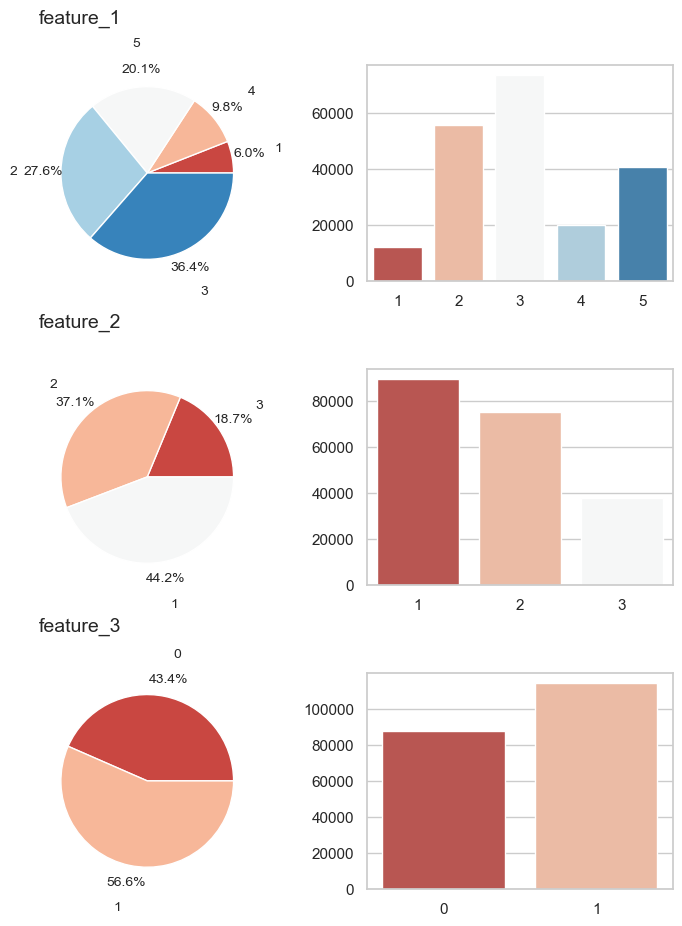

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
cols = ['feature_1', 'feature_2', 'feature_3']
n_cat_samples(userscore_df, cols, figsize=(7,12))

Text(0, 0.5, 'Count')

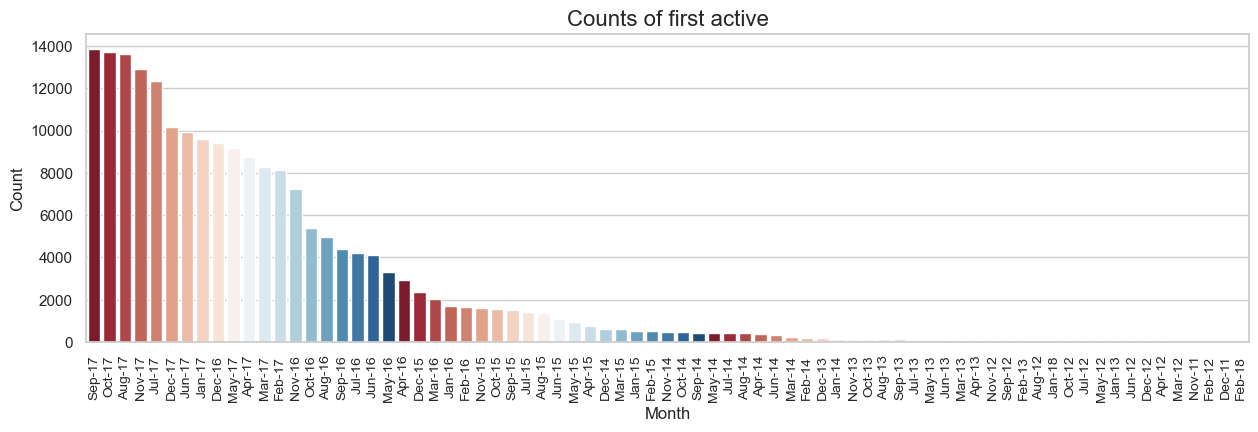

In [ ]:
plt.figure(figsize=(15,4))
active_month = userscore_df['first_active_month'].value_counts()
sns.barplot(x=active_month.index, y=active_month.values,palette=palette_color)
plt.xticks(rotation=90, fontsize=10)
plt.title('Counts of first active',fontsize=16)
plt.xlabel('Month')
plt.ylabel('Count')

<a ><font size="3"><b>OBSERVATION:</b></font></a> There are more active month in the 17th of each month.

### Closer Look at `score`
Check Score Loyality Distribution

Text(0.5, 1.0, 'QQ plot of score')

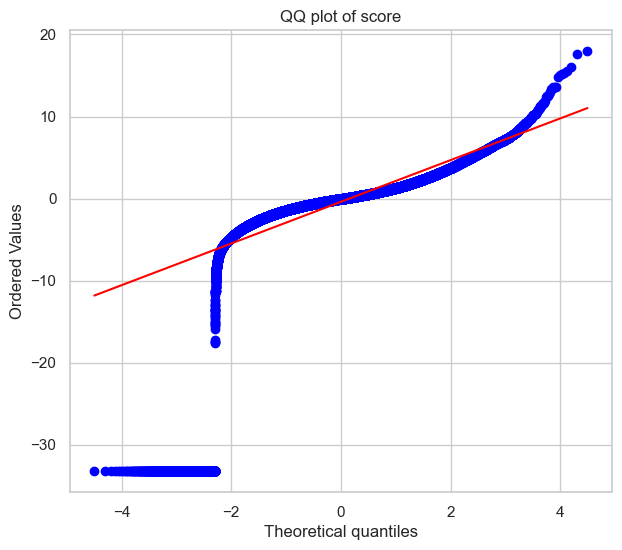

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
plt.figure(figsize=(7,6))
stats.probplot(userscore_df['score'], dist="norm", plot=plt)
plt.title(f"QQ plot of score", fontsize = 12)

<AxesSubplot:xlabel='score', ylabel='Count'>

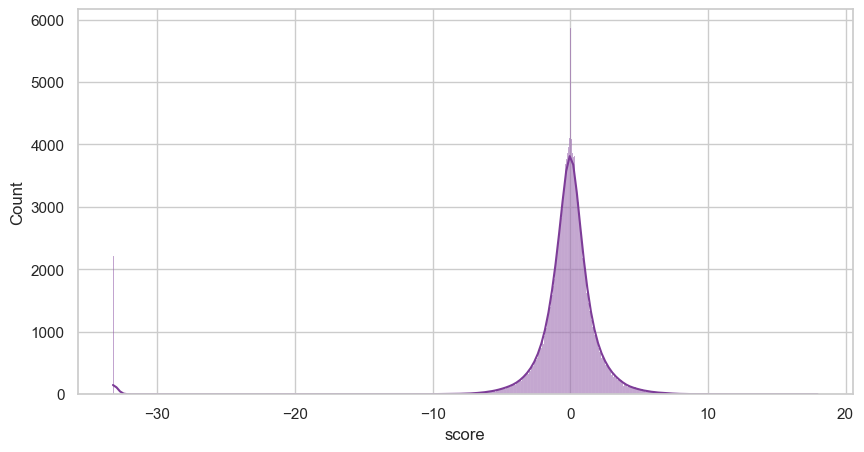

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(userscore_df['score'], kde=True,color = '#7D3C98')

In [ ]:
print(round(userscore_df[userscore_df.score < -30]['score'].\
      count() / userscore_df.shape[0], 4)*100, "% of the score is below -30")

1.09 % of the score is below -30


#### Separate the outliers from score

In [ ]:
critic_score_outliers = IQROutlierCheck(userscore_df,'score')

# Create two groups: outliers and non-outliers
score_outlier  = userscore_df.loc[critic_score_outliers.index]
score_non_outlier  = userscore_df.loc[~userscore_df.index.isin(critic_score_outliers.index)]

# Calculate the mean and standard deviation of each group
score_outlier_mean = score_outlier ['score'].mean()
score_outlier_std = score_outlier ['score'].std()
score_non_outlier_mean = score_non_outlier ['score'].mean()
score_non_outlier_std = score_non_outlier ['score'].std()
333
# Print the results
print('Loyalty Score Outlier Mean:', score_outlier_mean)
print('Loyalty Score Outlier Std:', score_outlier_std)
print('Loyalty Score Non-Outlier Mean:', score_non_outlier_mean)
print('Loyalty Score Non-Outlier Std:', score_non_outlier_std)

Loyalty Score Outlier Mean: -1.0054313259958865
Loyalty Score Outlier Std: 9.167192226776208
Loyalty Score Non-Outlier Mean: -0.27271357536311436
Loyalty Score Non-Outlier Std: 1.0288030125143808


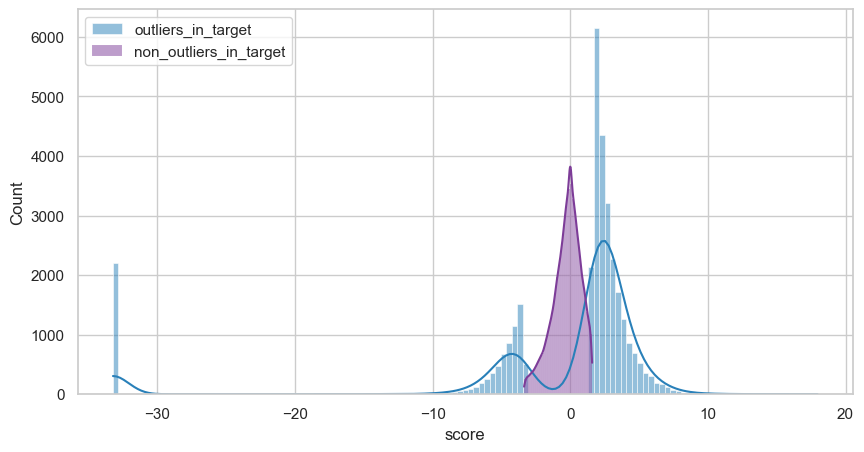

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(score_outlier['score'],label=('outliers_in_target'), kde=True,color = '#2980B9')
sns.histplot(score_non_outlier['score'],label=('non_outliers_in_target'), kde=True,color = '#7D3C98')
plt.legend(loc='upper left')

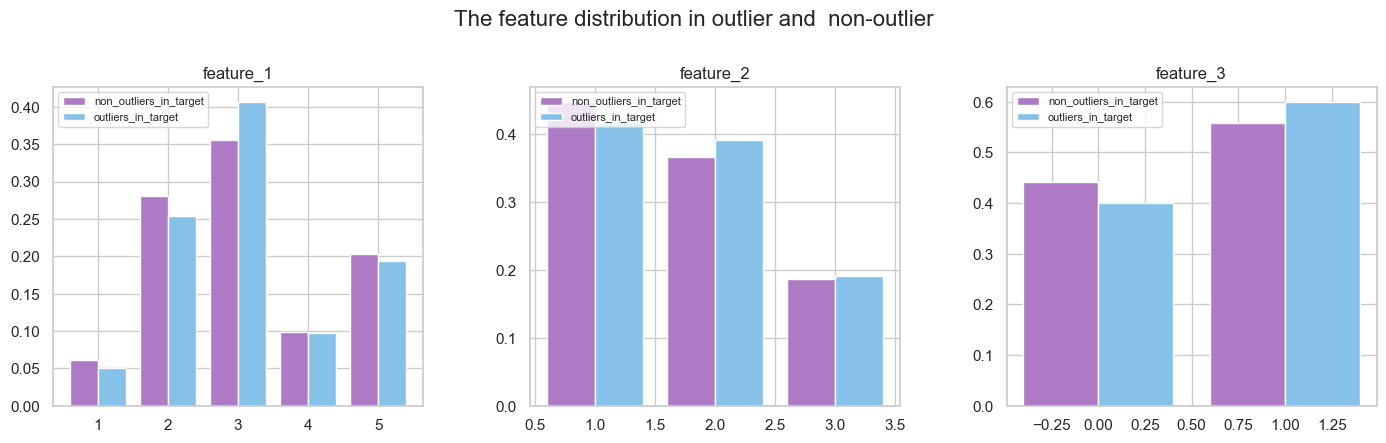

In [ ]:
plt.figure(figsize=[15,5])
cols= ['feature_1', 'feature_2', 'feature_3']
for i,col in enumerate(cols):
    plt.subplot(1,3,i+1)

    non_outliers=score_non_outlier[col].value_counts() /score_non_outlier.shape[0]
    outliers=score_outlier[col].value_counts() /score_outlier.shape[0]

    plt.bar(non_outliers.index, non_outliers,label=('non_outliers_in_target'),align='edge',width=-0.4,color=['#AF7AC5'])
    plt.bar(outliers.index, outliers,label=('outliers_in_target'),align='edge',width=0.4,color=['#85C1E9'])
    plt.title(col,fontsize=12)
    plt.legend(loc='upper left',fontsize=8)
    plt.tight_layout(pad=4, h_pad=0.9)

plt.suptitle('The feature distribution in outlier and  non-outlier', fontsize=16)
plt.show()

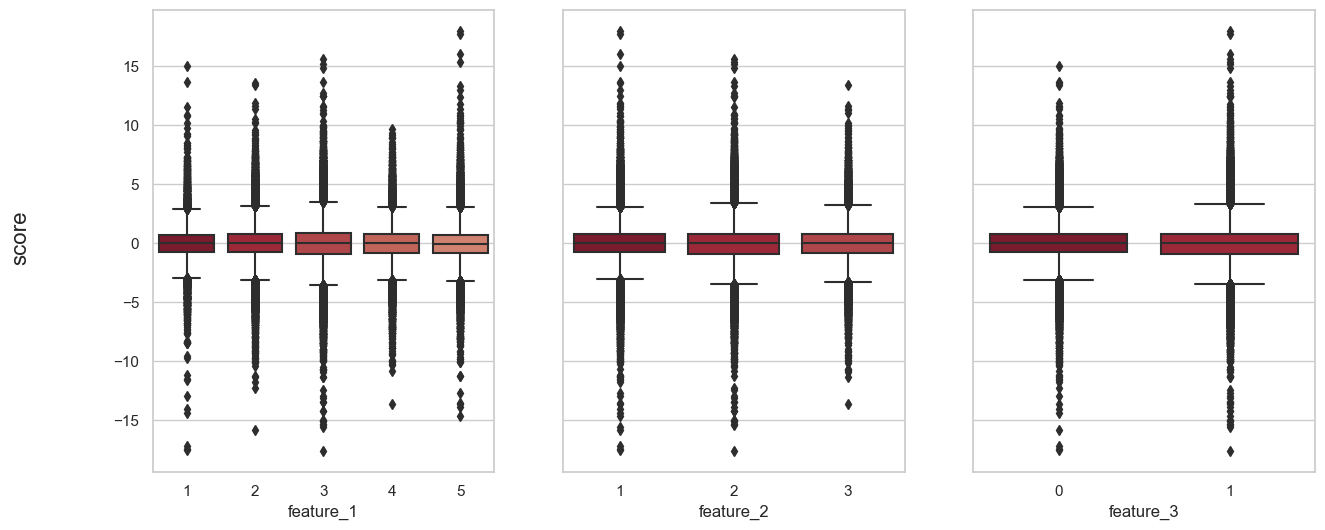

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

for i,col in enumerate(cols):

    sns.boxplot(y='score', x=col, data=userscore_df[userscore_df.score>-30], ax=axs[i])
    axs[i].set_ylabel('')

fig.text(0.03, 0.5, 'score', va='center', rotation='vertical', fontsize=16)
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a> The differences between the outliers and non-outliers in feature_1, feature_2, and feature_3 are negligible, implying that their inclusion in the dataset could potentially cause issues during training. It would be better to **exclude these values from the dataset**.



### Descriptive Statistics

In [ ]:
stats_df = DescriptiveStats(userscore_df)
stats_df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,skewness,kurtosis
card_id,201917,201917,C_ID_92a2005557,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_active_month,201917,75,Sep-17,13878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feature_1,201917.000,5,3,73573,3.105,1.186,1.000,2.000,3.000,4.000,5.000,0.305,-0.858
feature_2,201917.000,3,1,89242,1.745,0.751,1.000,1.000,2.000,2.000,3.000,0.455,-1.110
feature_3,201917.000,2,1,114198,0.566,0.496,0.000,0.000,1.000,1.000,1.000,-0.265,-1.930
score,201917.000,197110,-33.219,2207,-0.394,3.850,-33.219,-0.883,-0.023,0.765,17.965,-6.720,55.032


### Feature Engineering in userscore dataset

#### Aggregation over `first_active_month`

In [ ]:
import datetime
userscore_df['first_active_month'] = pd.to_datetime(userscore_df['first_active_month'], format='%b-%y')
userscore_df['year_of_joining'] = userscore_df['first_active_month'].dt.year
userscore_df['quarter_first_active_month'] = userscore_df['first_active_month'].dt.quarter
userscore_df['first_active_month_diff_from_today_in_days'] = (datetime.datetime.today() - userscore_df['first_active_month']).dt.days

del userscore_df['first_active_month']

In [ ]:
userscore_df.head(5)

,card_id,feature_1,feature_2,feature_3,score,year_of_joining,quarter_first_active_month,first_active_month_diff_from_today_in_days
0,C_ID_92a2005557,5,2,1,-0.820,2017,2,2189
1,C_ID_3d0044924f,4,1,0,0.393,2017,1,2340
2,C_ID_d639edf6cd,2,2,0,0.688,2016,3,2493
3,C_ID_186d6a6901,4,3,0,0.142,2017,3,2097
4,C_ID_cdbd2c0db2,1,3,0,-0.160,2017,4,2036


#### Aggregation over `feature_1, feature_2, feature_3`

In [ ]:
userscore_df['rare_data'] = 0
userscore_df.loc[critic_score_outliers.index, 'rare_data'] = 1
cols = ['feature_1', 'feature_2', 'feature_3']

for col in cols:
    rare_data_mean = userscore_df.groupby([col])['rare_data'].mean()
    userscore_df[col] = userscore_df[col].map(rare_data_mean)

    userscore_df['days_' + col] = userscore_df['first_active_month_diff_from_today_in_days'] * userscore_df[col]
    userscore_df['days_' + col + '_ratio'] = userscore_df[col] / userscore_df['first_active_month_diff_from_today_in_days']

In [ ]:
userscore_df['features_sum']  = userscore_df[cols].apply(lambda x: np.sum(x), axis=1)
userscore_df['features_mean'] = userscore_df[cols].apply(lambda x: np.mean(x), axis=1)
userscore_df['features_max']  = userscore_df[cols].apply(lambda x: np.max(x), axis=1)
userscore_df['features_min']  = userscore_df[cols].apply(lambda x: np.min(x), axis=1)
userscore_df['features_std']  = userscore_df[cols].apply(lambda x: np.std(x), axis=1)

In [ ]:
userscore_df.shape

(201917, 20)

In [ ]:
userscore_df.to_csv('agg_userscore_df.csv', index=False)

---
## Merchant Transaction Data Exploration
---

**Merchants Dataset Description:** contains aggregate information for each merchant_id represented in the data set.

![image.png](attachment:6f714ec3-7863-4239-870a-ebd1d777e46c.png)

### Dataset overview

In [ ]:
merchant_df = pd.read_csv("merchants.csv")

In [ ]:
InteractiveShell.ast_node_interactivity = "all"
merchant_df.shape
merchant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

<a ><font size="3"><b>OBSERVATION:</b></font></a>
-  `active_months_lag3`, `active_months_lag6`, `avg_sales_lag3`, `avg_sales_lag6`, `avg_purchases_lag3`, and `avg_purchases_lag6` are redundant features.
    - **Action:** Remove them

### Handling incosistancy

<a ><font size="3"><b>Check Duplication</b></font></a>


In [ ]:
all_ids = merchant_df.merchant_id.shape[0]
unique_ids = merchant_df.merchant_id.unique().shape[0]
print("Number of merchant_id \t\t=",all_ids)
print("Number of unique merchant_id\t=",unique_ids)
print("Number of duplicated samples\t=",all_ids - unique_ids)

Number of merchant_id 		= 334696
Number of unique merchant_id	= 334633
Number of duplicated samples	= 63


In [ ]:
merchant_df.drop_duplicates(subset=['merchant_id'], inplace=True)

In [ ]:
all_ids = merchant_df.merchant_id.shape[0]
unique_ids = merchant_df.merchant_id.unique().shape[0]
print("Number of merchant_id \t\t=",all_ids)
print("Number of unique merchant_id\t=",unique_ids)
print("Number of duplicated samples\t=",all_ids - unique_ids)

Number of merchant_id 		= 334633
Number of unique merchant_id	= 334633
Number of duplicated samples	= 0


In [ ]:
reduce_mem_usage(merchant_df)

Mem. usage decreased to 32.87 Mb (44.0% reduction)


merchant_id                     object
merchant_group_id                int32
merchant_category_id             int16
subsector_id                      int8
numerical_1                    float16
numerical_2                    float16
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float32
avg_purchases_lag3             float64
active_months_lag3                int8
avg_sales_lag6                 float32
avg_purchases_lag6             float64
active_months_lag6                int8
avg_sales_lag12                float32
avg_purchases_lag12            float64
active_months_lag12               int8
category_4                      object
city_id                          int16
state_id                          int8
category_2                     float16
dtype: object

<a ><font size="3"><b> Eliminate uninformative variables</b></font></a>


In [ ]:
merchant_df.drop(['merchant_group_id', 'merchant_category_id', 'subsector_id','city_id',
               'active_months_lag3', 'active_months_lag6', 'avg_sales_lag3',
               'avg_sales_lag6','avg_purchases_lag3','avg_purchases_lag6'],
              axis = 1, inplace = True)

<a ><font size="3"><b>Rename some variables to avoid conflict</b></font></a>


In [ ]:
merchant_df.rename(columns={'category_1':'merchant_category_1',
                         'category_2':'merchant_category_2',
                         'category_4':'merchant_category_3',
                         'numerical_1':'merchant_numerical_1',
                         'numerical_2':'merchant_numerical_2',
                         'state_id': 'merchant_state_id'}, inplace = True)

### Handling missing values

In [ ]:
missing_df = CheckMissing(merchant_df)
missing_df

,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,merchant_category_2,11863,3.545,5,1.000
1,avg_sales_lag12,13,0.004,5009,1.000


<AxesSubplot:>

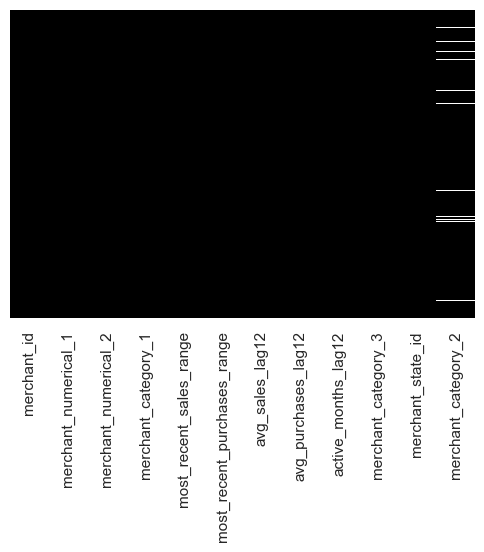

In [ ]:
plt.rc('figure', figsize=(6,4))
sns.heatmap(merchant_df.isna(),yticklabels = False, cbar = False, cmap = 'Greys_r')

<AxesSubplot:>

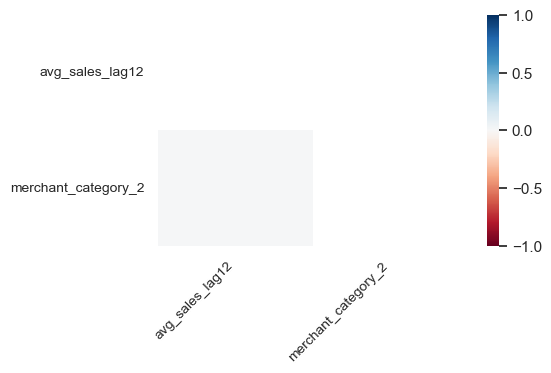

In [ ]:
msno.heatmap(merchant_df, figsize = (5,3), fontsize=10)

<AxesSubplot:>

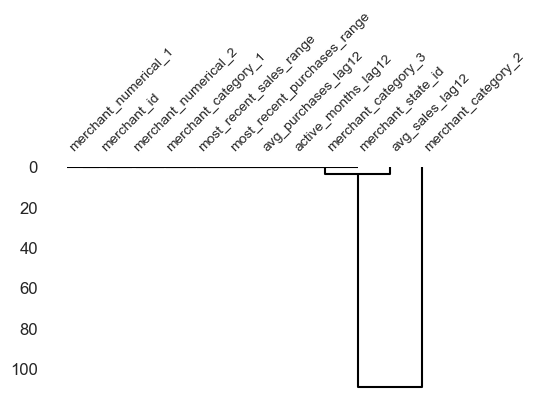

In [ ]:
msno.dendrogram(merchant_df, figsize = (5,3), fontsize=10,)

In [ ]:
missing_pattern = merchant_df[merchant_df['merchant_state_id'] == -1]['merchant_category_2'].isnull().value_counts()
print(missing_pattern)

True    11863
Name: merchant_category_2, dtype: int64


<a ><font size="3"><b>OBSERVATION:</b></font></a>
- The pattern in the output indicates that there are 11,863 missing values in the `merchant_category_2` column when the state_id is -1.
        
        - PATTERN: MNAT as the missing values are related to other variables in the dataset and cannot be explained by the observed data alone.

 - The pattern in `avg_sales_lag12` pattern is MCAT.
        
        

<a ><font size="3"><b>Drop missing in `avg_sales_lag12`</b></font></a>


In [ ]:
merchant_df.dropna(subset=['avg_sales_lag12'], inplace=True)

<a ><font size="3"><b>Fill missing in `state_id`</b></font></a>


In [ ]:
mode = merchant_df['merchant_category_2'].mode()[0]
merchant_df['merchant_category_2'].fillna(mode, inplace=True)

In [ ]:
CheckMissing(merchant_df)

Dataset has No Nulls


0

<a ><font size="3"><b>Check infinity values</b></font></a>


In [ ]:
for col in merchant_df.columns:
    has_inf = np.isinf(pd.to_numeric(merchant_df[col], errors='coerce')).any().any()
    if has_inf:
        print(f"{col} contains infinity values.")

### Handling oultiers

In [ ]:
cols = ['avg_purchases_lag12','avg_sales_lag12','merchant_numerical_2','merchant_numerical_1']
OutliersInfo(merchant_df, cols)


avg_purchases_lag12
-----------------------------------
Number of outlier samples produced by IQR is 57372
0% percentile value is 0.098
1% percentile value is 0.450
98% percentile value is 7.556
99% percentile value is 16.110
100% percentile value is 50215.556

	- Number of values less than 0.45 is 3343
	- Number of values greater than 16.109791666399985 is 3347

avg_sales_lag12
-----------------------------------
Number of outlier samples produced by IQR is 56829
0% percentile value is -82.130
1% percentile value is 0.360
98% percentile value is 10.296
99% percentile value is 23.906
100% percentile value is 2567408.000

	- Number of values less than 0.36000001430511475 is 3185
	- Number of values greater than 23.906199760436966 is 3347

merchant_numerical_2
-----------------------------------
Number of outlier samples produced by IQR is 52674
0% percentile value is -0.057
1% percentile value is -0.057
98% percentile value is 0.458
99% percentile value is 1.043
100% percentile value i

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- The intersections between `avg_purchases_lag12` and `avg_sales_lag12` will be relatively large, since both represent average purchase and sales metrics. Their percentile ranges significantly overlap. `merchant_numerical_1` and `merchant_numerical_2` also overlap considerably.

- For all the columns, the 100 percentile value is much larger than the 99 percentile value, indicating that there may be extreme values that are much larger than the rest of the data. Also, the 0 percentile value is much lower than the 1 percentile value, indicating that there may be extreme values that are much larger than the rest of the data.

    > I will remove the outliers and keep values whose percentile between 1% to 99%.

In [ ]:
merchant_df.shape
merchant_df = merchant_df[(merchant_df['avg_sales_lag12']> 0.45) & (merchant_df['avg_sales_lag12']< 24)]
merchant_df = merchant_df[(merchant_df['avg_purchases_lag12']> 0.45) & (merchant_df['avg_purchases_lag12']< 24)]
merchant_df = merchant_df[(merchant_df['merchant_numerical_1']<2)]
merchant_df.shape

(334620, 12)

(320604, 12)

In [ ]:
similarity  = sum(merchant_df.merchant_numerical_1== merchant_df.merchant_numerical_2)/len(merchant_df)
print(f"Similarity between merchant_numerical_1 and merchant_numerical_2 is {round(similarity * 100,2)}%")

Similarity between merchant_numerical_1 and merchant_numerical_2 is 90.06%


In [ ]:
similarity  = sum(merchant_df.most_recent_sales_range== merchant_df.most_recent_purchases_range)/len(merchant_df)
print(f"Similarity between most_recent_sales_range and most_recent_purchases_range is {round(similarity * 100,2)}%")

Similarity between most_recent_sales_range and most_recent_purchases_range is 70.67%


<a ><font size="3"><b>OBSERVATION:</b></font></a>

- The `merchant_numerical_1` and `merchant_numerical_2` alomst identical
     - **Action:** Drop one of them.

In [ ]:
merchant_df = merchant_df.drop('merchant_numerical_2', axis=1)

### Descriptive Statistics

In [ ]:
stats_df = DescriptiveStats(merchant_df)
stats_df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,skewness,kurtosis
merchant_id,320604,320604,M_ID_2be211b847,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_numerical_1,320604.000,208,-0.057,217502,-0.025,0.143,-0.057,-0.057,-0.057,-0.048,1.995,NaN,NaN
merchant_category_1,320604,2,N,314220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
most_recent_sales_range,320604,5,E,169184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
most_recent_purchases_range,320604,5,E,165008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_sales_lag12,320604.000,2133,1.000,5520,1.407,1.728,0.460,0.860,1.030,1.280,23.990,6.967,60.424
avg_purchases_lag12,320604.000,165870,1.000,1719,1.339,1.408,0.450,0.906,1.046,1.263,23.931,7.800,78.890
active_months_lag12,320604.000,12,12,294056,11.621,1.489,1.000,12.000,12.000,12.000,12.000,-4.479,20.680
merchant_category_3,320604,2,N,229441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_state_id,320604.000,25,9,88945,11.878,6.161,-1.000,9.000,10.000,16.000,24.000,0.039,-0.743


- The `merchant_numerical_1` feature look more like a categorical feature than numerical.Both the features take only _**208**_ distinct values comparing that there are a lot of data points.


### Explore some variables
Create a pie plot to visualize the count of samples for each category in each categorical column of the merchants dataset.

In [ ]:
cols = ['merchant_category_1', 'most_recent_sales_range',
        'most_recent_purchases_range', 'active_months_lag12',
        'merchant_category_3', 'merchant_category_2',]

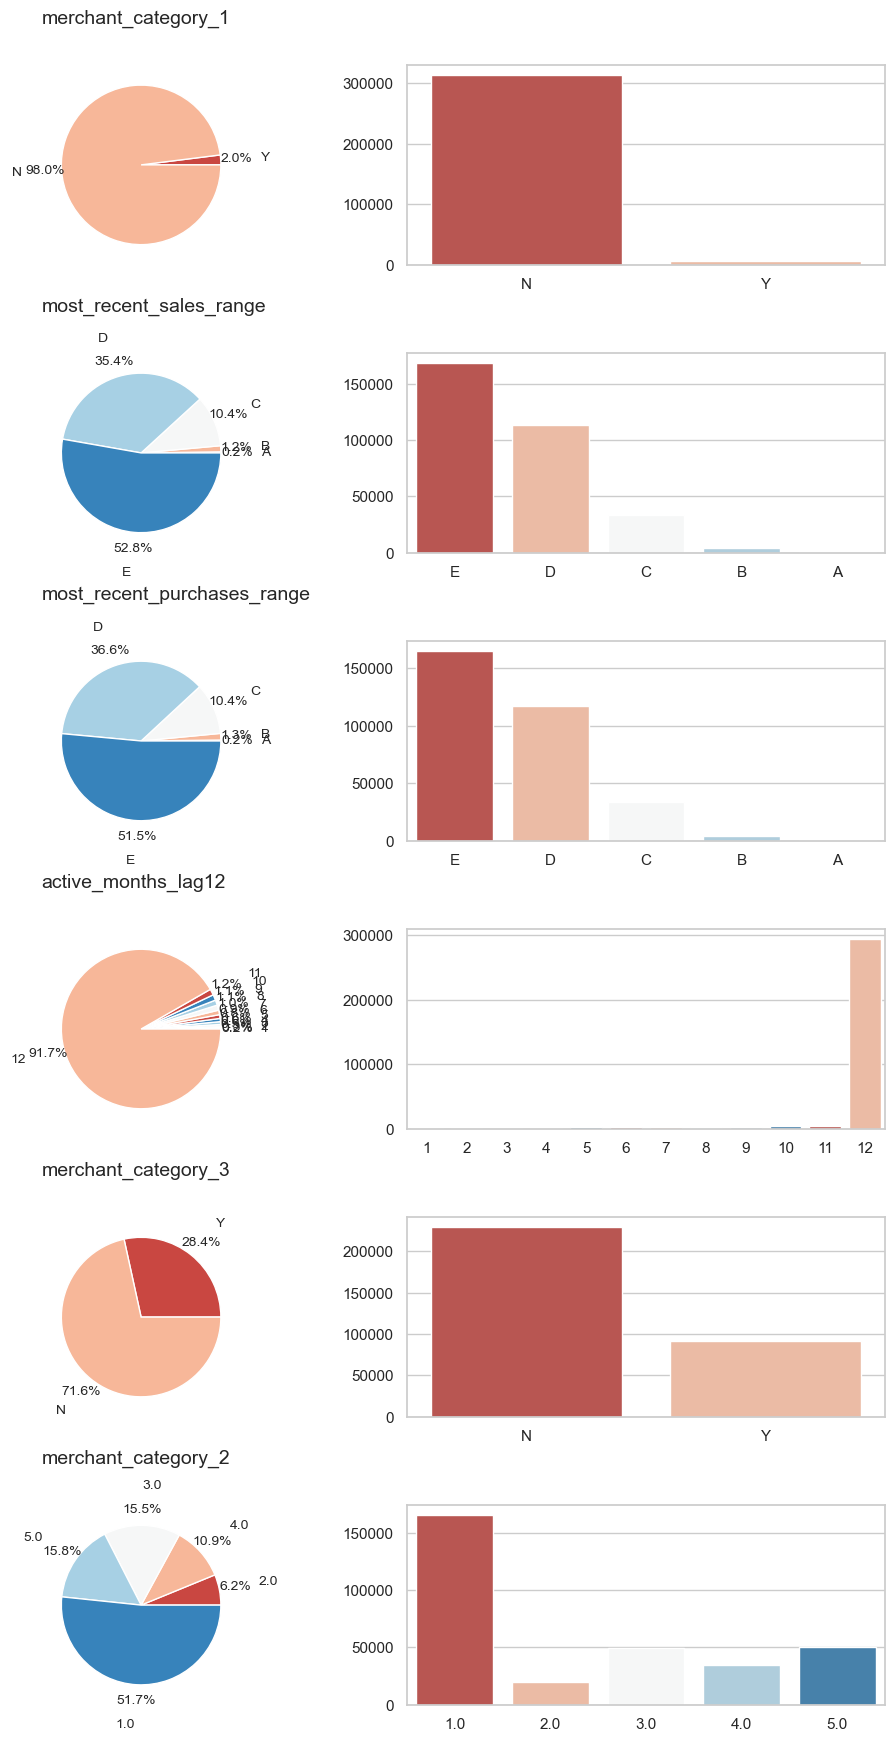

In [ ]:
n_cat_samples(merchant_df, cols, num_bins=10)

<a ><font size="3"><b>OBSERVATION:</b></font></a> The majority of the values (over 300,000) are 12, indicating that most of the cards in the dataset were active for all 12 months prior to the reference month.

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- `most_resent_sales_range` is the range of revenue (monetary units) in last active month --> A > B > C > D > E. `most_resent_purchases_range`is the range of quantity of transactions in last active month --> A > B > C > D > E.
    
    - The customers who make more transactions also generate more revenue.

### Check Normality

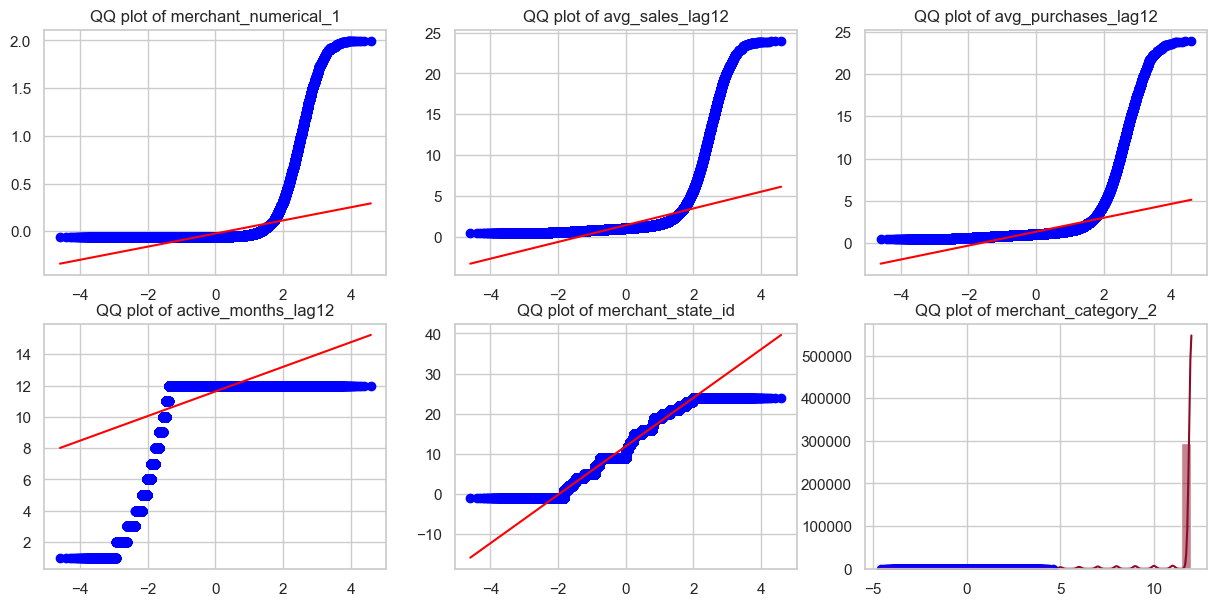

In [ ]:
cols = merchant_df.select_dtypes([np.number]).columns
QQplot(merchant_df, cols)

### Feature Encoding

In [ ]:
merchant_df['merchant_category_1'] = merchant_df['merchant_category_1'].map({'Y':1, 'N':0})
merchant_df['merchant_category_3'] = merchant_df['merchant_category_3'].map({'Y':1, 'N':0})

merchant_df['most_recent_sales_range'] = merchant_df['most_recent_sales_range'].map({'A':1, 'B':2, 'C':3, 'E':4, 'D':5})
merchant_df['most_recent_purchases_range'] = merchant_df['most_recent_purchases_range'].map({'A':1, 'B':2, 'C':3, 'E':4, 'D':5})

### Aggregated Features

In [ ]:
# Group by 'merchant_id' and compute informative features
import statistics
aggregations = {
    'merchant_state_id': ['nunique', statistics.mode],
    'merchant_category_1': ['mean', statistics.mode],
    'merchant_category_2': ['mean', statistics.mode],
    'merchant_category_3': ['mean', statistics.mode],
    'most_recent_sales_range': ['mean', statistics.mode],
    'most_recent_purchases_range': ['mean', statistics.mode],
    'active_months_lag12': [statistics.mode],
    'merchant_numerical_1': ['sum', 'mean', 'min', 'max', statistics.mode],
    'avg_sales_lag12': ['sum', 'mean', 'min', 'max'],
    'avg_purchases_lag12': ['sum', 'mean', 'min', 'max'],

}
agg_merchant_df = merchant_df.groupby('merchant_id').agg(aggregations)
agg_merchant_df.head(3)

merchant_state_id      merchant_category_1       \
                          nunique mode                mean mode   
merchant_id                                                       
M_ID_000025127f                 1    9               0.000    0   
M_ID_0000699140                 1    9               0.000    0   
M_ID_00006a5552                 1   15               0.000    0   

                merchant_category_2       merchant_category_3       \
                               mean  mode                mean mode   
merchant_id                                                          
M_ID_000025127f               1.000 1.000               1.000    1   
M_ID_0000699140               1.000 1.000               0.000    0   
M_ID_00006a5552               1.000 1.000               0.000    0   

                most_recent_sales_range      most_recent_purchases_range       \
                                   mean mode                        mean mode   
merchant_id                                                                     
M_ID_000025127f                   4.000    4                       4.000    4   
M_ID_0000699140                   5.000    5                       5.000    5   
M_ID_00006a5552                   4.000    4                       4.000    4   

                active_months_lag12 merchant_numerical_1                       \
                               mode                  sum   mean    min    max   
merchant_id                                                                     
M_ID_000025127f                  12               -0.057 -0.057 -0.057 -0.057   
M_ID_0000699140                  12               -0.057 -0.057 -0.057 -0.057   
M_ID_00006a5552                  12               -0.057 -0.057 -0.057 -0.057   

                       avg_sales_lag12                   avg_purchases_lag12  \
                  mode             sum  mean   min   max                 sum   
merchant_id                                                                    
M_ID_000025127f -0.057           1.080 1.080 1.080 1.080               2.090   
M_ID_0000699140 -0.057           1.240 1.240 1.240 1.240               1.155   
M_ID_00006a5552 -0.057           1.220 1.220 1.220 1.220               1.036   

                                   
                 mean   min   max  
merchant_id                        
M_ID_000025127f 2.090 2.090 2.090  
M_ID_0000699140 1.155 1.155 1.155  
M_ID_00006a5552 1.036 1.036 1.036

In [ ]:
agg_merchant_df.columns = ['_'.join(col).strip() for col in agg_merchant_df.columns.values]
agg_merchant_df = agg_merchant_df.reset_index()
agg_merchant_df.head(3)

,merchant_id,merchant_state_id_nunique,merchant_state_id_mode,merchant_category_1_mean,merchant_category_1_mode,merchant_category_2_mean,merchant_category_2_mode,merchant_category_3_mean,merchant_category_3_mode,most_recent_sales_range_mean,most_recent_sales_range_mode,most_recent_purchases_range_mean,most_recent_purchases_range_mode,active_months_lag12_mode,merchant_numerical_1_sum,merchant_numerical_1_mean,merchant_numerical_1_min,merchant_numerical_1_max,merchant_numerical_1_mode,avg_sales_lag12_sum,avg_sales_lag12_mean,avg_sales_lag12_min,avg_sales_lag12_max,avg_purchases_lag12_sum,avg_purchases_lag12_mean,avg_purchases_lag12_min,avg_purchases_lag12_max
0,M_ID_000025127f,1,9,0.000,0,1.000,1.000,1.000,1,4.000,4,4.000,4,12,-0.057,-0.057,-0.057,-0.057,-0.057,1.080,1.080,1.080,1.080,2.090,2.090,2.090,2.090
1,M_ID_0000699140,1,9,0.000,0,1.000,1.000,0.000,0,5.000,5,5.000,5,12,-0.057,-0.057,-0.057,-0.057,-0.057,1.240,1.240,1.240,1.240,1.155,1.155,1.155,1.155
2,M_ID_00006a5552,1,15,0.000,0,1.000,1.000,0.000,0,4.000,4,4.000,4,12,-0.057,-0.057,-0.057,-0.057,-0.057,1.220,1.220,1.220,1.220,1.036,1.036,1.036,1.036


In [ ]:
agg_merchant_df.shape

(320604, 27)

In [ ]:
agg_merchant_df.to_csv('agg_merchant_df.csv', index=False)

---
## Transaction Data Exploration
---

- **New Merchant Dataset Description:** contains the transactions at new merchants (merchant ids that this particular card id has not yet visited) over two months.

- **Historcal Merchant Transaction Dataset Description:** contains up to 3 months’ worth of transactions for every card at any of the provided merchant ids. all the variable is the same as `new_merchant_transactions`.

![image.png](attachment:e7823a20-b09b-47ca-bceb-b5b8a99d011a.png)

### Load Dataset

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'
new_merch_tran_df = pd.read_csv("new_merchant_transactions.csv")
new_merch_tran_df.shape

(1963031, 14)

In [ ]:
hist_tran_df = pd.read_csv("historical_transactions.csv")
hist_tran_df.shape

(29112361, 14)

In [ ]:
# create new column to identify if the sample from the `new_merchant_transactions.csv` or `historical_transactions.csv`
new_merch_tran_df['new_transaction'] = 'Y'
hist_tran_df['new_transaction'] = 'N'

In [ ]:
new_merch_tran_df.authorized_flag.unique()
hist_tran_df.authorized_flag.value_counts()

array(['Y'], dtype=object)

Y    26595452
N     2516909
Name: authorized_flag, dtype: int64

In [ ]:
reduce_mem_usage(new_merch_tran_df)
reduce_mem_usage(hist_tran_df)

Mem. usage decreased to 129.17 Mb (42.5% reduction)


authorized_flag          object
card_id                  object
city_id                   int16
category_1               object
installments              int16
category_3               object
merchant_category_id      int16
merchant_id              object
month_lag                  int8
purchase_amount         float16
purchase_date            object
category_2              float16
state_id                   int8
subsector_id               int8
new_transaction          object
dtype: object

Mem. usage decreased to 1971.22 Mb (40.8% reduction)


authorized_flag          object
card_id                  object
city_id                   int16
category_1               object
installments              int16
category_3               object
merchant_category_id      int16
merchant_id              object
month_lag                  int8
purchase_amount         float32
purchase_date            object
category_2              float16
state_id                   int8
subsector_id               int8
new_transaction          object
dtype: object

<a ><font size="3"><b>OBSERVATION:</b></font></a> All new transacations are authorized

### Join the transactions datasets

By combining this transaction data with demographic information about the customers, we can perform statistical analysis to identify correlations between customer behavior and loyalty scores.

In [ ]:
transactions_df = pd.concat([hist_tran_df, new_merch_tran_df], axis = 0)
transactions_df.shape

(31075392, 15)

In [ ]:
transactions_df.info()

In [ ]:
transactions_df.duplicated().sum()

In [ ]:
transactions_df = transactions_df.drop_duplicates(keep='first')

### Handling inconsistancy

In [ ]:
# Rename some variables to avoid conflict
transactions_df.rename(columns={'category_1':'transactions_category_1',
                       'category_2':'transactions_category_2',
                       'category_3':'transactions_category_3',
                        'state_id': 'transactions_state_id',
                        'city_id': 'transactions_city_id'}, inplace = True)

### Chcek missing values

In [ ]:
missing_df = CheckMissing(transactions_df)
missing_df

,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,transactions_category_2,2764609,8.896,5,1.000
1,transactions_category_3,234081,0.753,3,A
2,merchant_id,164697,0.530,334633,M_ID_00a6ca8a8a


In [ ]:
# sns.heatmap(transactions_df.isna(),yticklabels = False, cbar = False, cmap = 'Greys_r')

In [ ]:
msno.heatmap(transactions_df[missing_df.Feature], figsize = (5,3), fontsize=10)

In [ ]:
msno.dendrogram(transactions_df[missing_df.Feature], figsize = (5,3), fontsize=10,)

In [ ]:
both_null = transactions_df['transactions_category_3'].isna() & transactions_df['merchant_id'].isna()
count_both_null = both_null.sum()
print('Number of rows where both columns are null:', count_both_null)

Number of rows where both columns are null: 9389


In [ ]:
count_both_null / missing_df.loc[2,'NumMissing']

0.05700771720189196

In [ ]:
missing_pattern = transactions_df[transactions_df['transactions_category_3'].isna()]['merchant_id'].value_counts()[:10]
print(missing_pattern)

M_ID_59764e8cb1    1588
M_ID_725a60d404     866
M_ID_d0146c836a     746
M_ID_d13262f4b0     586
M_ID_879f625c89     568
M_ID_b7459adc65     543
M_ID_4e461f7e14     528
M_ID_ad49138777     504
M_ID_afae7eb4cc     458
M_ID_6495f1c97d     419
Name: merchant_id, dtype: int64


<a ><font size="3"><b>OBSERVATION:</b></font></a>
Missing pattern in `transactions_category_2`, `transactions_category_3` and `merchant_id` are MCAT. I will impute these variables using the most frequenly value for each of them.

<a ><font size="3"><b>Imputation </b></font></a>

In [ ]:
# impute by mode
for col in missing_df.Feature:
    mode = transactions_df[col].mode()[0]
    transactions_df[col].fillna(mode, inplace=True)

### Check outliers

In [ ]:
cols = ['installments', 'month_lag', 'purchase_amount','transactions_category_2']
OutliersInfo(transactions_df, cols)


installments
-----------------------------------
Number of outlier samples produced by IQR is 1993620
0% percentile value is -1.000
1% percentile value is 0.000
98% percentile value is 4.000
99% percentile value is 6.000
100% percentile value is 999.000

	- Number of values less than 0.0 is 234081
	- Number of values greater than 6.0 is 226769

month_lag
-----------------------------------
Number of outlier samples produced by IQR is 0
0% percentile value is -13.000
1% percentile value is -13.000
98% percentile value is 2.000
99% percentile value is 2.000
100% percentile value is 2.000

	- Number of values less than -13.0 is 0
	- Number of values greater than 2.0 is 0

purchase_amount
-----------------------------------
Number of outlier samples produced by IQR is 5371814
0% percentile value is -0.747
1% percentile value is -0.743
98% percentile value is 0.455
99% percentile value is 1.240
100% percentile value is 6010604.000

	- Number of values less than -0.7431662082672119 is 30768

In [ ]:
transactions_df.installments.value_counts()

 0      16333991
 1      12513700
 2        721145
 3        582957
-1        234081
 4        194340
 6        143023
 10       127726
 5        125386
 12        57914
 8         22029
 7         11769
 9          6250
 11          891
 999         190
Name: installments, dtype: int64

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- `installments` should be between 0–12 months, however we can see month value of -1 and 999 which may be some error or wrong entries.


In [ ]:
transactions_df.shape
transactions_df = transactions_df[transactions_df['purchase_amount']< 2]
transactions_df = transactions_df[(transactions_df['installments'] != -1)&(transactions_df['installments'] != 999)]
transactions_df.shape

(30664765, 15)

### Descriptive Statistics

In [ ]:
stats_df = DescriptiveStats(transactions_df)
stats_df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,skewness,kurtosis
authorized_flag,30664765,2,Y,28217603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card_id,30664765,325526,C_ID_3d3dfdc692,5579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transactions_city_id,30664765.000,308,69,5108819,129.729,104.076,-1.000,54.000,91.000,212.000,347.000,0.589,-0.848
transactions_category_1,30664765,2,N,28564107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installments,30664765.000,13,0,16302699,0.636,1.105,0.000,0.000,0.000,1.000,12.000,5.019,37.711
transactions_category_3,30664765,3,A,16302699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
merchant_category_id,30664765.000,328,705,5708499,478.562,249.273,-1.000,302.000,454.000,705.000,891.000,-0.086,-1.178
merchant_id,30664765,331617,M_ID_00a6ca8a8a,1287802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month_lag,30664765.000,16,-2,3788135,-4.134,3.767,-13.000,-7.000,-3.000,-1.000,2.000,-0.578,-0.524
purchase_amount,30664765.000,163172,-0.672,686741,-0.547,0.242,-0.747,-0.720,-0.689,-0.608,2.000,4.964,31.808


### Explore some variables graphically
Create a pie plot to visualize the count of samples for each category in some columns of the merchants dataset.

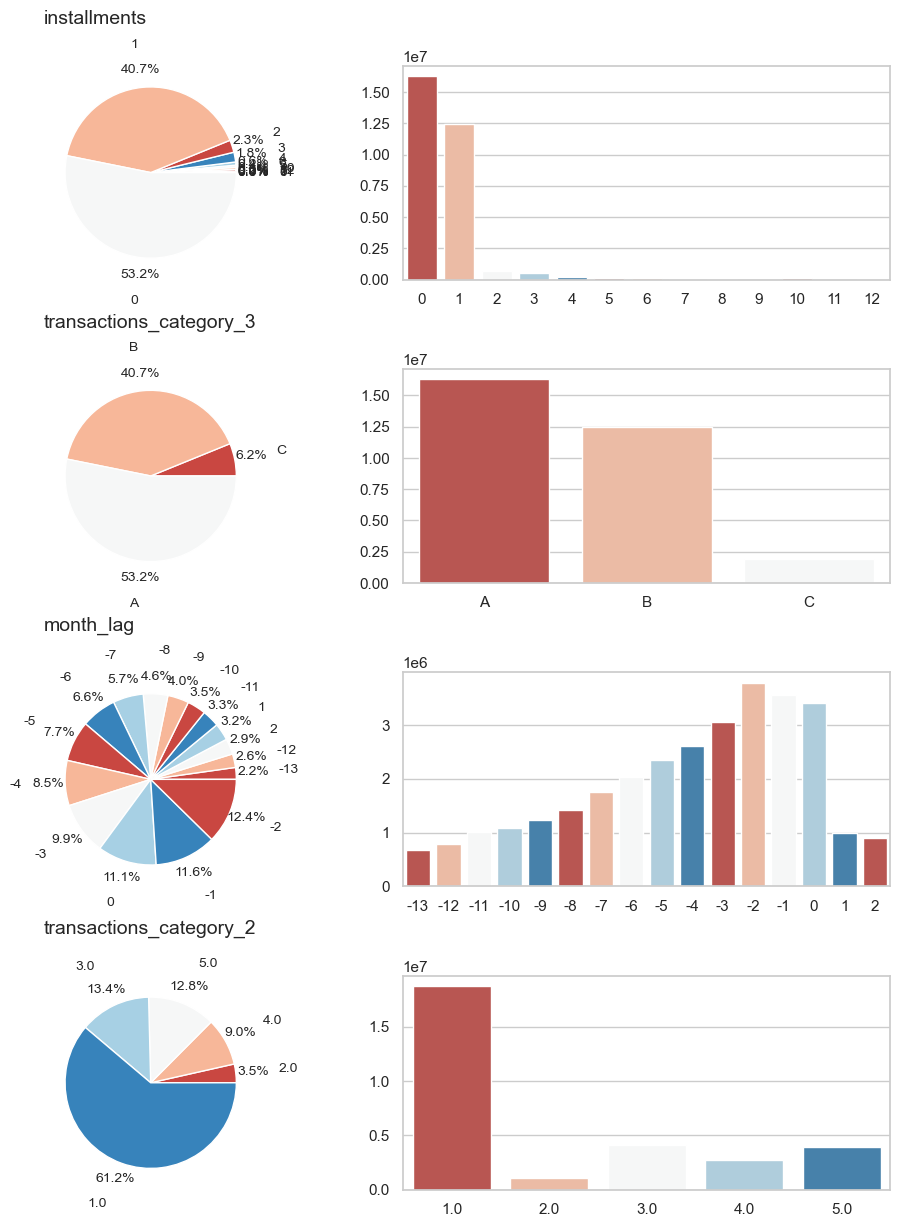

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'

cols = ['installments','transactions_category_3','month_lag', 'transactions_category_2']
n_cat_samples(transactions_df, cols, figsize=(10,15))

<a ><font size="3"><b>OBSERVATION:</b></font></a>

- Most of the transactions happen with 0,1 installments.
- Users purchase more on **Saturday** than any other day.
- Most puraches transactions occured in **March** and **April**.
- Most puraches transactions occured at **morning** and **afternoon**.

<a ><font size="3"><b>Closer Look at `merchant_id` variable</b></font></a>

Number of samples for each merchant id

In [ ]:
top50_merch = transactions_df.merchant_id.value_counts().sort_values(ascending = False)[:50]

In [ ]:
top50_merch.values[0] / top50_merch.values[-1]

51.739734833266375

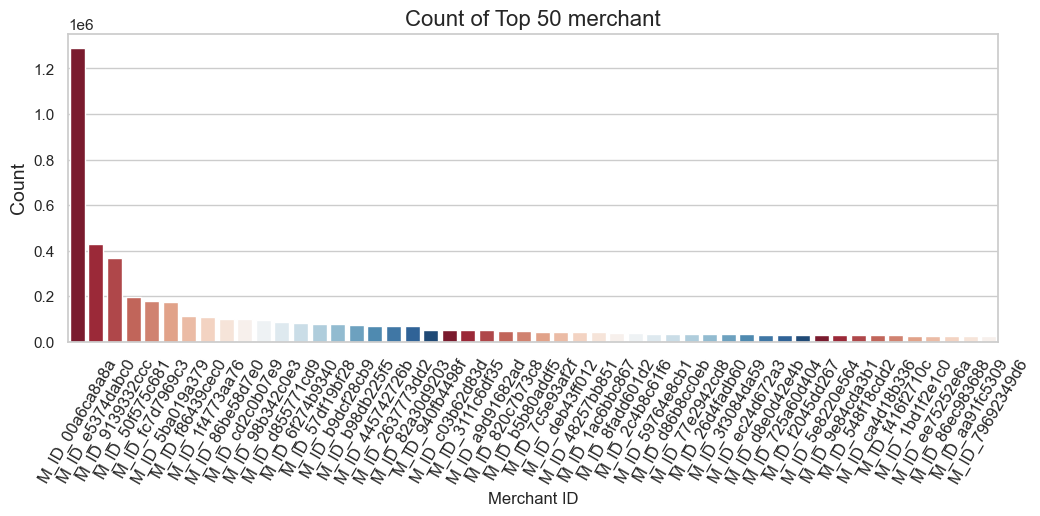

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
plt.rc('figure', figsize=(12,4))

sns.barplot(x = top50_merch.index, y = top50_merch.values, palette=palette_color)
plt.xticks(rotation=60, fontsize=12)
plt.xlabel("Merchant ID", fontsize=12)
plt.ylabel("Count", fontsize=14)
plt.title("Count of Top 50 merchant", fontsize=16)
plt.show()

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- The distribution of transaction volumes among the merchants appears to follow a power-law distribution, with a few merchants having very high transaction volumes and most merchants having relatively low transaction volumes.
- The top merchant has a transaction volume that is more than 50 times higher than the lowest merchant.

<a ><font size="3"><b> Closer Look at `card_id` variable</b></font></a>


In [ ]:
top50_card = transactions_df.card_id.value_counts().sort_values(ascending = False)[:50]

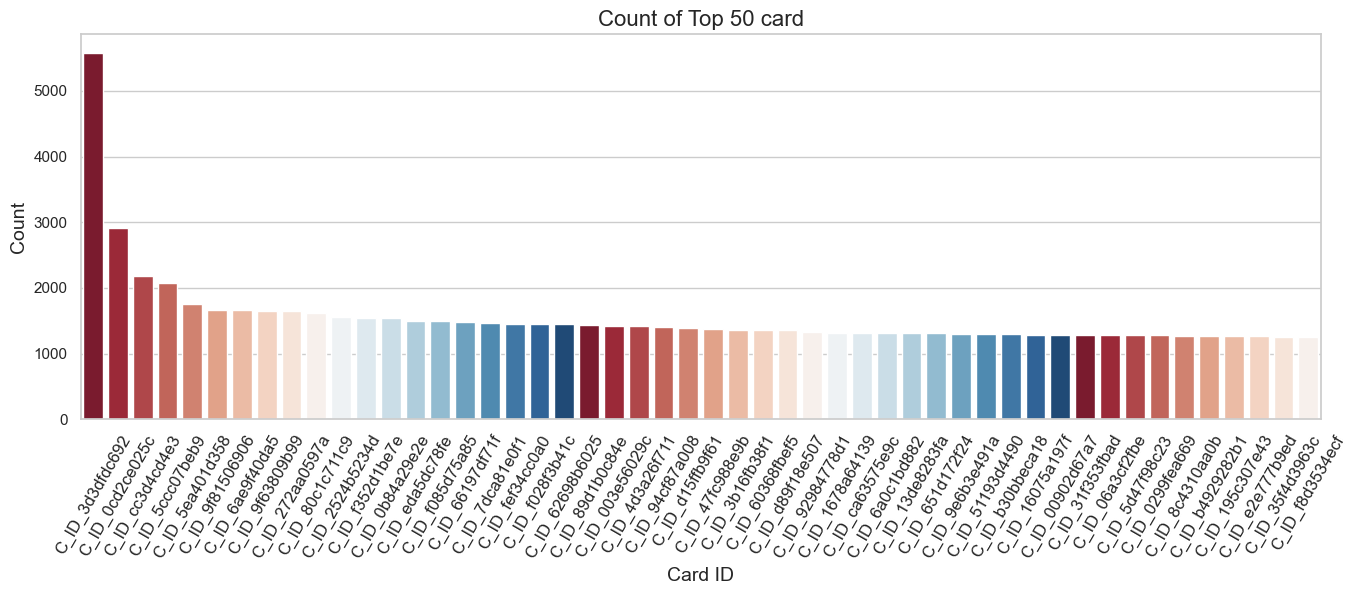

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
plt.rc('figure', figsize=(16,5))

sns.barplot(x = top50_card.index, y = top50_card.values, palette=palette_color)
plt.xticks(rotation=60, fontsize=12)
plt.xlabel("Card ID", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Count of Top 50 card", fontsize=16)
plt.show()

In [ ]:
top50_card.values[0] / top50_card.values[-1]

4.4348171701112875

<a ><font size="3"><b>OBSERVATION:</b></font></a>
- The top card has a transaction volume that is more than 4 times higher than the lowest merchant.
- one card has high transaction volume and the rest have similr

In [ ]:
top50_card_id_sample = transactions_df[transactions_df.card_id.isin(top50_card.index)]
# top50_card_id_sample = trans.loc[is_top_50]

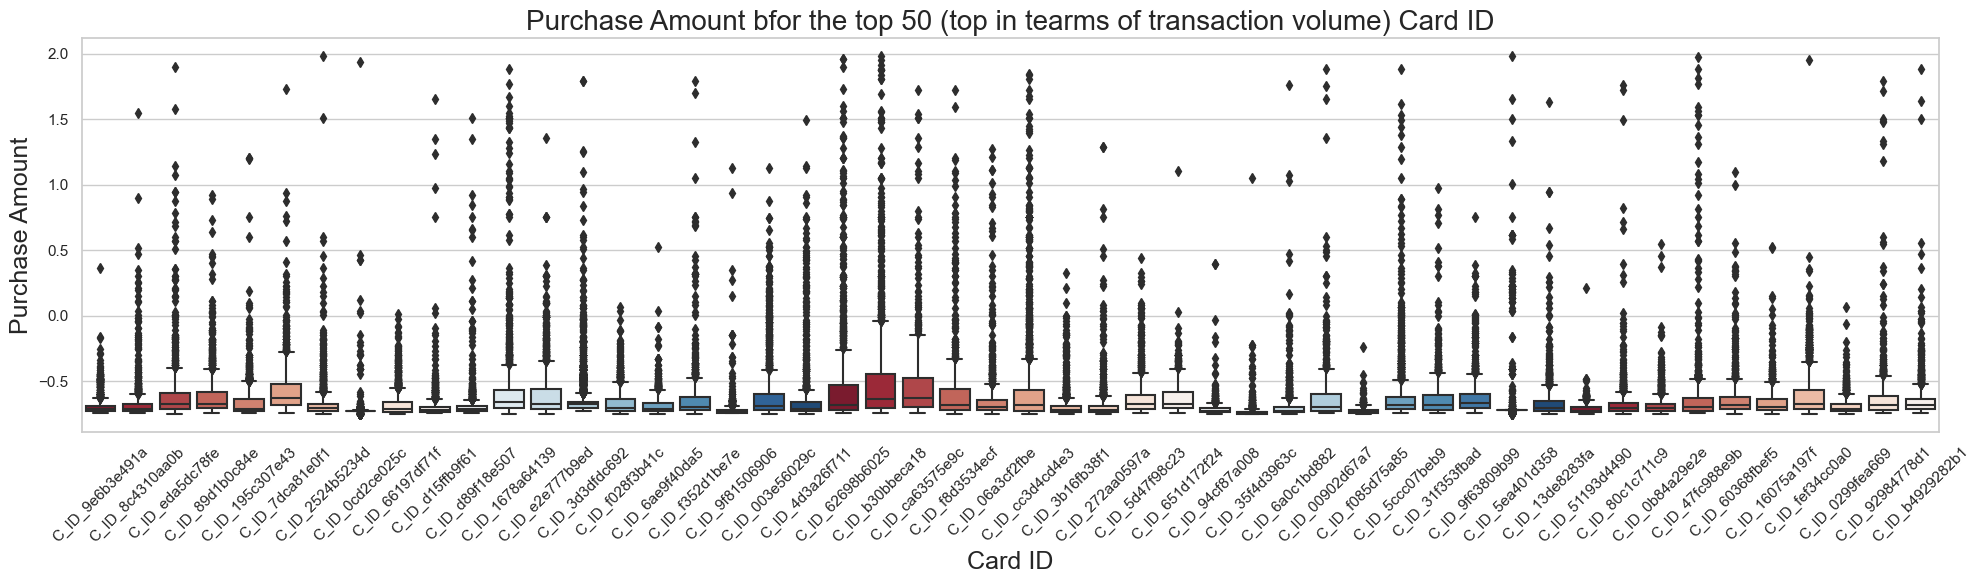

In [ ]:
InteractiveShell.ast_node_interactivity = 'last_expr'
plt.rc('figure', figsize=(20,6))

sns.boxplot(x='card_id', y='purchase_amount', data=top50_card_id_sample, palette = palette_color)
plt.xlabel('Card ID', fontsize=18)
plt.xticks(rotation=45)
plt.ylabel('Purchase Amount', fontsize=18)
plt.title('Purchase Amount bfor the top 50 (top in tearms of transaction volume) Card ID', fontsize=20)
plt.tight_layout()

<a ><font size="3"><b>OBSERVATION:</b></font></a>The purchase amount distribution of the top 50 card IDs, which are selected based on their total purchase amount, are diffrent.

### Feature Encoding

In [ ]:
cats2 = ['authorized_flag', 'transactions_category_1', 'new_transaction']
for col in cats2:
    transactions_df[col] = transactions_df[col].map({'Y': 1, 'N': 0})

In [ ]:
transactions_df['transactions_category_3'] = transactions_df['transactions_category_3'].map({'A': 1, 'B': 2, 'C': 3})

### Merge transactions with merchants

<Figure size 500x500 with 0 Axes>

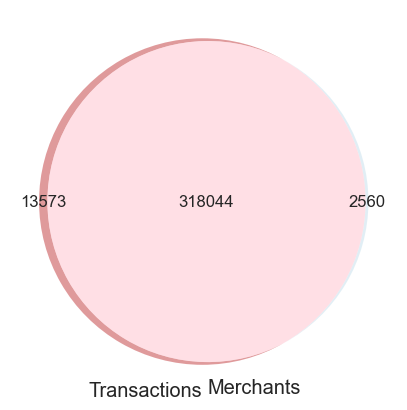

In [ ]:
from matplotlib_venn import venn2
plt.figure(figsize=(5,5))

ids1 = set(transactions_df['merchant_id'].values)
ids2 = set(agg_merchant_df['merchant_id'].values)
venn2([ids1, ids2],set_labels = ('Transactions', 'Merchants'),set_colors=palette_color[2::10], alpha=0.5)

<a ><font size="3"><b>OBSERVATION:</b></font></a> There are 14,030 merchantID lack matching details about the relevant merchants in the merchant dataset.

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'
transactions_df.shape
transactions = pd.merge(transactions_df, agg_merchant_df, on = 'merchant_id', how = 'inner')
transactions.shape

(30664765, 48)

(25502010, 74)

<a ><font size="3"><b>Chcek missing values</b></font></a>

In [ ]:
missing_df = CheckMissing(transactions)
missing_df

Dataset has No Nulls


0

### Feature Engineering

Following [Rjt5412](https://github.com/Rjt5412/Elo-Merchant-Category-Recommendation) i will add three new columns in the `transactions_df` dataframe: `purchase_year`, `purchase_month`, and `purchase_dow`, which contain the year, month, and day of the week for each transaction, respectively. The dayofweek attribute returns the day of the week as an integer, where Monday is 0 and Sunday is 6. Note that we have also converted the year and month columns to categorical data type, as they are categorical variables.
**Steps:**
1. Converting the `purchase_date` column to a datetime object.
2. Creating new columns for weekday, weekend indicator, month, day of year, week of year, hour, and holiday indicator.
3. Calculating the number of months since each transaction using `month_diff`.

<a ><font size="3"><b>Featurization on `purchase_date` and `month_lag`</b></font></a>


In [ ]:
import datetime
transactions['purchase_date']  = pd.to_datetime(transactions['purchase_date'], format='%Y-%m-%d %H:%M:%S')

# Create columns for the purchase year, month, day of week, and hour.
transactions['purchase_year']  = transactions.purchase_date.dt.year
transactions['purchase_month'] = transactions.purchase_date.dt.month
transactions['purchase_dow']   = transactions.purchase_date.dt.dayofweek
transactions['purchase_hour']  = transactions.purchase_date.dt.hour

# reate a categorical column indicating the part of the day the purchase was made - night, morning, afternoon or evening.
transactions['purchase_part_day'] = pd.cut(transactions['purchase_hour'] , [-1, 5, 12, 17, 23],
                                            labels=['night', 'morning', 'afternoon', 'evening'])

# Create a column indicating if the purchase was on a weekend or not.
transactions['is_weekend']     = transactions.purchase_dow.apply(lambda day: 1 if day == 5 or day == 6 else 0)

# Calculate the number of months since each purchase
current_date = datetime.date.today()
transactions['month_diff']     = ((current_date  - transactions.purchase_date.dt.date).dt.days)//30
transactions['month_diff']    += transactions['month_lag']

transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

In [ ]:
transactions.head(3)

,authorized_flag,card_id,transactions_city_id,transactions_category_1,installments,transactions_category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,transactions_category_2,transactions_state_id,subsector_id,new_transaction,merchant_state_id_nunique_x,merchant_state_id_mode_x,merchant_category_1_mean_x,merchant_category_1_mode_x,merchant_category_2_mean_x,merchant_category_2_mode_x,merchant_category_3_mean_x,merchant_category_3_mode_x,most_recent_sales_range_mean_x,most_recent_sales_range_mode_x,most_recent_purchases_range_mean_x,most_recent_purchases_range_mode_x,active_months_lag12_mode_x,merchant_numerical_1_sum_x,merchant_numerical_1_mean_x,merchant_numerical_1_min_x,merchant_numerical_1_max_x,merchant_numerical_1_mode_x,avg_sales_lag12_sum_x,avg_sales_lag12_mean_x,avg_sales_lag12_min_x,avg_sales_lag12_max_x,avg_purchases_lag12_sum_x,avg_purchases_lag12_mean_x,avg_purchases_lag12_min_x,avg_purchases_lag12_max_x,purchase_year,purchase_month,purchase_dow,purchase_hour,purchase_part_day,is_weekend,month_diff,merchant_state_id_nunique_y,merchant_state_id_mode_y,merchant_category_1_mean_y,merchant_category_1_mode_y,merchant_category_2_mean_y,merchant_category_2_mode_y,merchant_category_3_mean_y,merchant_category_3_mode_y,most_recent_sales_range_mean_y,most_recent_sales_range_mode_y,most_recent_purchases_range_mean_y,most_recent_purchases_range_mode_y,active_months_lag12_mode_y,merchant_numerical_1_sum_y,merchant_numerical_1_mean_y,merchant_numerical_1_min_y,merchant_numerical_1_max_y,merchant_numerical_1_mode_y,avg_sales_lag12_sum_y,avg_sales_lag12_mean_y,avg_sales_lag12_min_y,avg_sales_lag12_max_y,avg_purchases_lag12_sum_y,avg_purchases_lag12_mean_y,avg_purchases_lag12_min_y,avg_purchases_lag12_max_y
0,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733,2017-07-15 12:10:45,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,7,5,12,morning,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-8,-0.733,2017-06-11 13:11:52,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,6,6,13,afternoon,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062
2,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-4,-0.722,2017-10-01 14:36:11,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,10,6,14,afternoon,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062


In [ ]:
import statistics
agg_dict = {
    'month_diff': ['sum', 'mean', 'min', 'max', ],
    'purchase_date' : [np.ptp, 'min', 'max'],
    'purchase_year':[statistics.mode],
    'purchase_month': ['sum', 'mean',statistics.mode],
    'purchase_dow':[statistics.mode],
    'is_weekend': ['sum', 'mean',statistics.mode],
    'merchant_id':['nunique',statistics.mode],
}

agg_purchase_date = transactions.groupby('card_id').agg(agg_dict).reset_index()
agg_purchase_date.head(5)

card_id month_diff                    purchase_date  \
                          sum   mean min max               ptp   
0  C_ID_00007093c1       7927 63.927  63  64 419 days 00:36:14   
1  C_ID_0001238066       7925 63.911  63  64 213 days 21:32:16   
2  C_ID_0001506ef0       3777 64.017  64  65 431 days 16:58:29   
3  C_ID_0001793786      14538 67.935  67  69 344 days 07:20:35   
4  C_ID_000183fdda       8882 63.899  63  64 262 days 03:57:04   

                                          purchase_year purchase_month        \
                  min                 max          mode            sum  mean   
0 2017-02-14 15:47:45 2018-04-09 16:23:59          2017            787 6.347   
1 2017-09-28 22:25:14 2018-04-30 19:57:30          2017            852 6.871   
2 2017-01-14 16:16:01 2018-03-22 09:14:30          2017            393 6.661   
3 2017-01-21 10:15:21 2017-12-31 17:35:56          2017           1539 7.192   
4 2017-08-07 09:49:14 2018-04-26 13:46:18          2017            932 6.705   

       purchase_dow is_weekend            merchant_id                   
  mode         mode        sum  mean mode     nunique             mode  
0    8            0         15 0.121    0          24  M_ID_9400cf2342  
1   12            5         59 0.476    0          75  M_ID_d17aabd756  
2   12            5         29 0.492    0          22  M_ID_b1fc88154d  
3    9            3         39 0.182    0         128  M_ID_923d57de8d  
4    2            2         33 0.237    0          74  M_ID_f9cfe0a43b

In [ ]:
agg_purchase_date.columns = ['trans_'+'_'.join(col).strip() for col in agg_purchase_date.columns.values]
agg_purchase_date = agg_purchase_date.rename(columns={'trans_card_id_':'card_id',
                                                     'trans_merchant_id_mode':'merchant_id'})
agg_purchase_date.head(5)

,card_id,trans_month_diff_sum,trans_month_diff_mean,trans_month_diff_min,trans_month_diff_max,trans_purchase_date_ptp,trans_purchase_date_min,trans_purchase_date_max,trans_purchase_year_mode,trans_purchase_month_sum,trans_purchase_month_mean,trans_purchase_month_mode,trans_purchase_dow_mode,trans_is_weekend_sum,trans_is_weekend_mean,trans_is_weekend_mode,trans_merchant_id_nunique,merchant_id
0,C_ID_00007093c1,7927,63.927,63,64,419 days 00:36:14,2017-02-14 15:47:45,2018-04-09 16:23:59,2017,787,6.347,8,0,15,0.121,0,24,M_ID_9400cf2342
1,C_ID_0001238066,7925,63.911,63,64,213 days 21:32:16,2017-09-28 22:25:14,2018-04-30 19:57:30,2017,852,6.871,12,5,59,0.476,0,75,M_ID_d17aabd756
2,C_ID_0001506ef0,3777,64.017,64,65,431 days 16:58:29,2017-01-14 16:16:01,2018-03-22 09:14:30,2017,393,6.661,12,5,29,0.492,0,22,M_ID_b1fc88154d
3,C_ID_0001793786,14538,67.935,67,69,344 days 07:20:35,2017-01-21 10:15:21,2017-12-31 17:35:56,2017,1539,7.192,9,3,39,0.182,0,128,M_ID_923d57de8d
4,C_ID_000183fdda,8882,63.899,63,64,262 days 03:57:04,2017-08-07 09:49:14,2018-04-26 13:46:18,2017,932,6.705,2,2,33,0.237,0,74,M_ID_f9cfe0a43b


In [ ]:
agg_purchase_date['trans_purchase_date_ptp'] = agg_purchase_date['trans_purchase_date_ptp'].dt.days
agg_purchase_date['trans_purchase_date_max_diff_now'] = (datetime.datetime.today() - agg_purchase_date['trans_purchase_date_max']).dt.days
agg_purchase_date['trans_purchase_date_min_diff_now'] = (datetime.datetime.today() - agg_purchase_date['trans_purchase_date_min']).dt.days

del agg_purchase_date['trans_purchase_date_ptp']

agg_purchase_date.head(3)

,card_id,trans_month_diff_sum,trans_month_diff_mean,trans_month_diff_min,trans_month_diff_max,trans_purchase_date_min,trans_purchase_date_max,trans_purchase_year_mode,trans_purchase_month_sum,trans_purchase_month_mean,trans_purchase_month_mode,trans_purchase_dow_mode,trans_is_weekend_sum,trans_is_weekend_mean,trans_is_weekend_mode,trans_merchant_id_nunique,merchant_id,trans_purchase_date_max_diff_now,trans_purchase_date_min_diff_now
0,C_ID_00007093c1,7927,63.927,63,64,2017-02-14 15:47:45,2018-04-09 16:23:59,2017,787,6.347,8,0,15,0.121,0,24,M_ID_9400cf2342,1876,2295
1,C_ID_0001238066,7925,63.911,63,64,2017-09-28 22:25:14,2018-04-30 19:57:30,2017,852,6.871,12,5,59,0.476,0,75,M_ID_d17aabd756,1855,2069
2,C_ID_0001506ef0,3777,64.017,64,65,2017-01-14 16:16:01,2018-03-22 09:14:30,2017,393,6.661,12,5,29,0.492,0,22,M_ID_b1fc88154d,1895,2326


<a ><font size="3"><b> Featurization on `purchase_amount`</b></font></a>

Computes several aggregate statistics ontransactions the `purchase_amount` column for each group. The computed statistics are the minimum, maximum, mean, median, standard deviation, sum, and count.This aggregated data gives an overview of each customer's spending behavior:

- High maximum or average amounts indicate big ticket purchases
- A wide spread (high standard deviation) suggests irregular spending
- A high total spend sum purchase_amount captures overall expenditures
- The count of transactions reveals purchase frequency

In [ ]:
agg_purchase_amount = transactions.groupby('card_id')['purchase_amount']\
                       .agg(['min', 'max', 'mean', 'median', 'sum']).reset_index()
agg_purchase_amount.head(3)

,card_id,min,max,mean,median,sum
0,C_ID_00007093c1,-0.729,1.507,-0.537,-0.597,-66.601
1,C_ID_0001238066,-0.741,0.768,-0.582,-0.636,-72.206
2,C_ID_0001506ef0,-0.740,1.494,-0.505,-0.702,-29.804


In [ ]:
agg_purchase_amount.columns = ['trans_purchase_amount_'+str(col) for col in agg_purchase_amount.columns.values]
agg_purchase_amount = agg_purchase_amount.rename(columns={'trans_purchase_amount_card_id':'card_id'})
agg_purchase_amount.head(3)

,card_id,trans_purchase_amount_min,trans_purchase_amount_max,trans_purchase_amount_mean,trans_purchase_amount_median,trans_purchase_amount_sum
0,C_ID_00007093c1,-0.729,1.507,-0.537,-0.597,-66.601
1,C_ID_0001238066,-0.741,0.768,-0.582,-0.636,-72.206
2,C_ID_0001506ef0,-0.740,1.494,-0.505,-0.702,-29.804


<a ><font size="3"><b>Numerical Aggregated Features</b></font></a>


In [ ]:
dummies = pd.get_dummies(transactions['purchase_part_day'], prefix='purchase_at')
transactions = pd.concat([transactions, dummies], axis=1)
transactions.head(3)

,authorized_flag,card_id,transactions_city_id,transactions_category_1,installments,transactions_category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,transactions_category_2,transactions_state_id,subsector_id,new_transaction,merchant_state_id_nunique_x,merchant_state_id_mode_x,merchant_category_1_mean_x,merchant_category_1_mode_x,merchant_category_2_mean_x,merchant_category_2_mode_x,merchant_category_3_mean_x,merchant_category_3_mode_x,most_recent_sales_range_mean_x,most_recent_sales_range_mode_x,most_recent_purchases_range_mean_x,most_recent_purchases_range_mode_x,active_months_lag12_mode_x,merchant_numerical_1_sum_x,merchant_numerical_1_mean_x,merchant_numerical_1_min_x,merchant_numerical_1_max_x,merchant_numerical_1_mode_x,avg_sales_lag12_sum_x,avg_sales_lag12_mean_x,avg_sales_lag12_min_x,avg_sales_lag12_max_x,avg_purchases_lag12_sum_x,avg_purchases_lag12_mean_x,avg_purchases_lag12_min_x,avg_purchases_lag12_max_x,purchase_year,purchase_month,purchase_dow,purchase_hour,purchase_part_day,is_weekend,month_diff,merchant_state_id_nunique_y,merchant_state_id_mode_y,merchant_category_1_mean_y,merchant_category_1_mode_y,merchant_category_2_mean_y,merchant_category_2_mode_y,merchant_category_3_mean_y,merchant_category_3_mode_y,most_recent_sales_range_mean_y,most_recent_sales_range_mode_y,most_recent_purchases_range_mean_y,most_recent_purchases_range_mode_y,active_months_lag12_mode_y,merchant_numerical_1_sum_y,merchant_numerical_1_mean_y,merchant_numerical_1_min_y,merchant_numerical_1_max_y,merchant_numerical_1_mode_y,avg_sales_lag12_sum_y,avg_sales_lag12_mean_y,avg_sales_lag12_min_y,avg_sales_lag12_max_y,avg_purchases_lag12_sum_y,avg_purchases_lag12_mean_y,avg_purchases_lag12_min_y,avg_purchases_lag12_max_y,purchase_at_night,purchase_at_morning,purchase_at_afternoon,purchase_at_evening
0,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733,2017-07-15 12:10:45,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,7,5,12,morning,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-8,-0.733,2017-06-11 13:11:52,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,6,6,13,afternoon,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,0,0,1,0
2,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-4,-0.722,2017-10-01 14:36:11,1.000,16,16,0,1.000,16.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,12.000,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,2017,10,6,14,afternoon,1,64,1,16,0.000,0,1.000,1.000,1.000,1,1.000,1,1.000,1,12,1.093,1.093,1.093,1.093,1.093,1.050,1.050,1.050,1.050,1.062,1.062,1.062,1.062,0,0,1,0


In [ ]:
aggregations = {
    'authorized_flag' : ['sum', 'mean'],
    'transactions_category_1' : ['sum', 'mean', statistics.mode],
    'transactions_category_2' : ['sum', 'mean', statistics.mode],
    'transactions_category_3' : ['sum', 'mean', statistics.mode],
    'transactions_city_id' : ['nunique', statistics.mode],
    'transactions_state_id' : ['nunique', statistics.mode],
    'subsector_id' : ['nunique', statistics.mode],
    'merchant_category_id' : ['nunique', statistics.mode],
    'installments' : ['sum', 'mean', 'min', 'max', statistics.mode],
    'purchase_at_night': ['sum', 'mean', statistics.mode],
    'purchase_at_morning': ['sum', 'mean', statistics.mode],
    'purchase_at_afternoon':  ['sum', 'mean', statistics.mode],
    'purchase_at_evening':  ['sum', 'mean', statistics.mode],
}

agg_numerical_features = transactions.groupby('card_id').agg(aggregations)
agg_numerical_features.head(5)

authorized_flag       transactions_category_1             \
                            sum  mean                     sum  mean mode   
card_id                                                                    
C_ID_00007093c1              93 0.750                      28 0.226    0   
C_ID_0001238066             121 0.976                       4 0.032    0   
C_ID_0001506ef0              56 0.949                       0 0.000    0   
C_ID_0001793786             193 0.902                       2 0.009    0   
C_ID_000183fdda             133 0.957                       4 0.029    0   

                transactions_category_2             transactions_category_3  \
                                    sum  mean  mode                     sum   
card_id                                                                       
C_ID_00007093c1                 316.000 2.549 3.000                     264   
C_ID_0001238066                 200.000 1.613 1.000                     284   
C_ID_0001506ef0                 173.000 2.932 3.000                      60   
C_ID_0001793786                 325.000 1.519 1.000                     218   
C_ID_000183fdda                 401.000 2.885 3.000                     315   

                           transactions_city_id      transactions_state_id  \
                 mean mode              nunique mode               nunique   
card_id                                                                      
C_ID_00007093c1 2.129    2                    5  244                     4   
C_ID_0001238066 2.290    2                   17  314                     5   
C_ID_0001506ef0 1.017    1                    3  137                     2   
C_ID_0001793786 1.019    1                   11  179                     5   
C_ID_000183fdda 2.266    2                    8  161                     5   

                     subsector_id      merchant_category_id      installments  \
                mode      nunique mode              nunique mode          sum   
card_id                                                                         
C_ID_00007093c1    2           11   19                   15  307          154   
C_ID_0001238066    9           18   19                   31  307          223   
C_ID_0001506ef0   19           12   33                   16  705            1   
C_ID_0001793786   -1           25   37                   53  278            4   
C_ID_000183fdda    3           19   16                   32  367          261   

                                   purchase_at_night             \
                 mean min max mode               sum  mean mode   
card_id                                                           
C_ID_00007093c1 1.242   1   6    1             5.000 0.040    0   
C_ID_0001238066 1.798   1  10    1            13.000 0.105    0   
C_ID_0001506ef0 0.017   0   1    0             0.000 0.000    0   
C_ID_0001793786 0.019   0   1    0             9.000 0.042    0   
C_ID_000183fdda 1.878   1  10    1             7.000 0.050    0   

                purchase_at_morning            purchase_at_afternoon        \
                                sum  mean mode                   sum  mean   
card_id                                                                      
C_ID_00007093c1              36.000 0.290    0                51.000 0.411   
C_ID_0001238066              20.000 0.161    0                38.000 0.306   
C_ID_0001506ef0              32.000 0.542    1                23.000 0.390   
C_ID_0001793786              38.000 0.178    0                90.000 0.421   
C_ID_000183fdda              21.000 0.151    0                38.000 0.273   

                     purchase_at_evening             
                mode                 sum  mean mode  
card_id                                              
C_ID_00007093c1    0              32.000 0.258    0  
C_ID_0001238066    0              53.000 0.427    0  
C_ID_0001506ef0    0               4.000 0.068    0  
C_ID_000179378

In [ ]:
agg_numerical_features.columns = [str(level1)+'_'+str(level2) for level1, level2 in agg_numerical_features.columns.values]
agg_numerical_features = agg_numerical_features.reset_index()
agg_numerical_features.head(3)

,card_id,authorized_flag_sum,authorized_flag_mean,transactions_category_1_sum,transactions_category_1_mean,transactions_category_1_mode,transactions_category_2_sum,transactions_category_2_mean,transactions_category_2_mode,transactions_category_3_sum,transactions_category_3_mean,transactions_category_3_mode,transactions_city_id_nunique,transactions_city_id_mode,transactions_state_id_nunique,transactions_state_id_mode,subsector_id_nunique,subsector_id_mode,merchant_category_id_nunique,merchant_category_id_mode,installments_sum,installments_mean,installments_min,installments_max,installments_mode,purchase_at_night_sum,purchase_at_night_mean,purchase_at_night_mode,purchase_at_morning_sum,purchase_at_morning_mean,purchase_at_morning_mode,purchase_at_afternoon_sum,purchase_at_afternoon_mean,purchase_at_afternoon_mode,purchase_at_evening_sum,purchase_at_evening_mean,purchase_at_evening_mode
0,C_ID_00007093c1,93,0.750,28,0.226,0,316.000,2.549,3.000,264,2.129,2,5,244,4,2,11,19,15,307,154,1.242,1,6,1,5.000,0.040,0,36.000,0.290,0,51.000,0.411,0,32.000,0.258,0
1,C_ID_0001238066,121,0.976,4,0.032,0,200.000,1.613,1.000,284,2.290,2,17,314,5,9,18,19,31,307,223,1.798,1,10,1,13.000,0.105,0,20.000,0.161,0,38.000,0.306,0,53.000,0.427,0
2,C_ID_0001506ef0,56,0.949,0,0.000,0,173.000,2.932,3.000,60,1.017,1,3,137,2,19,12,33,16,705,1,0.017,0,1,0,0.000,0.000,0,32.000,0.542,1,23.000,0.390,0,4.000,0.068,0


In [ ]:
agg_transactions = pd.concat([agg_purchase_date, agg_numerical_features, agg_purchase_amount], axis = 1)
agg_transactions.shape

(325458, 62)

In [ ]:
agg_transactions.isna().sum().sum()

0

In [ ]:
import gc
gc.collect()

159

In [ ]:
agg_transactions.to_csv(r'G:\Assig 1\agg_transactions.csv', index=False)

---

<h1 style="text-align:center;"><font color = "#2471A3"> Hypothesis Testing</font></h1>

---


## Merge datasets

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'

transactions = pd.read_csv(r'G:\Assig 1\agg_transactions.csv')
transactions.shape
scores = pd.read_csv(r'G:\Assig 1\agg_userscore_df.csv')
scores.shape

(325458, 62)

(201917, 20)

<Figure size 600x600 with 0 Axes>

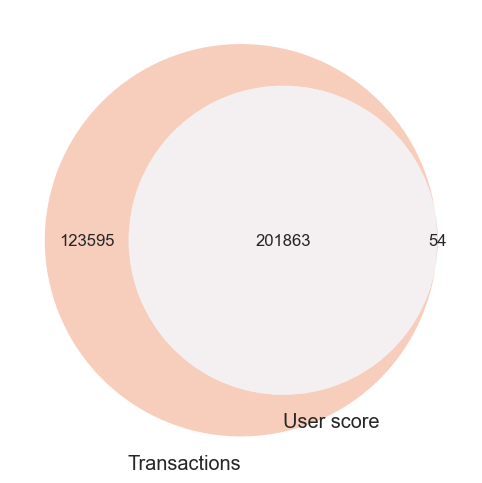

In [ ]:
from matplotlib_venn import venn2
plt.figure(figsize=(6,6))

ids1 = set(transactions['card_id'].values)
ids2 = set(scores['card_id'].values)
venn2([ids1, ids2],set_labels = ('Transactions', 'User score'),set_colors=palette_color[5::10], alpha=0.5)

In [ ]:
merged_df = pd.merge(scores, transactions, on='card_id', how='inner')
merged_df.shape

(201863, 81)

In [ ]:
merged_df.to_csv(r'G:\Assig 1\all_processed_data.csv', index = False)

In [ ]:
merged_df.sample(5)

,card_id,feature_1,feature_2,feature_3,score,year_of_joining,quarter_first_active_month,first_active_month_diff_from_today_in_days,rare_data,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,days_feature_3_ratio,features_sum,features_mean,features_max,features_min,features_std,trans_month_diff_sum,trans_month_diff_mean,trans_month_diff_min,trans_month_diff_max,trans_purchase_date_min,trans_purchase_date_max,trans_purchase_year_mode,trans_purchase_month_sum,trans_purchase_month_mean,trans_purchase_month_mode,trans_purchase_dow_mode,trans_is_weekend_sum,trans_is_weekend_mean,trans_is_weekend_mode,trans_merchant_id_nunique,merchant_id,trans_purchase_date_max_diff_now,trans_purchase_date_min_diff_now,card_id.1,authorized_flag_sum,authorized_flag_mean,transactions_category_1_sum,transactions_category_1_mean,transactions_category_1_mode,transactions_category_2_sum,transactions_category_2_mean,transactions_category_2_mode,transactions_category_3_sum,transactions_category_3_mean,transactions_category_3_mode,transactions_city_id_nunique,transactions_city_id_mode,transactions_state_id_nunique,transactions_state_id_mode,subsector_id_nunique,subsector_id_mode,merchant_category_id_nunique,merchant_category_id_mode,installments_sum,installments_mean,installments_min,installments_max,installments_mode,purchase_at_night_sum,purchase_at_night_mean,purchase_at_night_mode,purchase_at_morning_sum,purchase_at_morning_mean,purchase_at_morning_mode,purchase_at_afternoon_sum,purchase_at_afternoon_mean,purchase_at_afternoon_mode,purchase_at_evening_sum,purchase_at_evening_mean,purchase_at_evening_mode,card_id.2,trans_purchase_amount_min,trans_purchase_amount_max,trans_purchase_amount_mean,trans_purchase_amount_median,trans_purchase_amount_sum
59346,C_ID_befc3a8c0f,0.151,0.174,0.152,2.544,2015,1,3012,1,455.657,0.000,524.853,0.000,458.020,0.000,0.478,0.159,0.174,0.151,0.011,2302,63.944,63,65,2017-01-22 18:26:16,2018-04-30 20:13:27,2017,117,3.250,3,2,6,0.167,0,30,M_ID_b5b80addf5,1855,2318,C_ID_befc3a8c0f,36,1.000,0,0.000,0,40.000,1.111,1.000,36,1.000,1,3,69,3,9,8,19,13,307,0,0.000,0,0,0,1.000,0.028,0,7.000,0.194,0,11.000,0.306,0,17.000,0.472,0,C_ID_befc3a8c0f,-0.739,0.383,-0.609,-0.672,-21.908
415,C_ID_0f93e85034,0.151,0.156,0.152,-2.124,2017,3,2097,0,317.235,0.000,327.044,0.000,318.881,0.000,0.459,0.153,0.156,0.151,0.002,1069,66.812,66,67,2017-09-02 14:01:31,2017-12-29 09:43:10,2017,154,9.625,9,5,5,0.312,0,11,M_ID_0a11b43f2c,1978,2095,C_ID_0f93e85034,15,0.938,0,0.000,0,16.000,1.000,1.000,33,2.062,2,2,19,1,9,6,33,6,705,21,1.312,1,6,1,0.000,0.000,0,2.000,0.125,0,7.000,0.438,0,7.000,0.438,0,C_ID_0f93e85034,-0.740,-0.432,-0.680,-0.703,-10.876
119356,C_ID_c3518a29d5,0.184,0.174,0.175,-0.077,2016,4,2432,0,447.771,0.000,423.786,0.000,425.586,0.000,0.533,0.178,0.184,0.174,0.004,7930,63.952,63,65,2017-02-06 14:02:24,2018-04-16 12:01:47,2017,927,7.476,12,6,57,0.460,0,41,M_ID_434b95c768,1869,2303,C_ID_c3518a29d5,113,0.911,0,0.000,0,124.000,1.000,1.000,130,1.048,1,7,299,1,9,13,33,28,705,26,0.210,0,9,0,2.000,0.016,0,85.000,0.685,1,29.000,0.234,0,8.000,0.065,0,C_ID_c3518a29d5,-0.736,1.476,-0.518,-0.636,-64.239
35247,C_ID_1821fed43a,0.184,0.174,0.175,-1.208,2017,1,2340,0,430.833,0.000,407.755,0.000,409.487,0.000,0.533,0.178,0.184,0.174,0.004,2403,75.094,75,76,2017-01-31 10:38:09,2017-05-31 16:05:43,2017,90,2.812,2,4,8,0.250,0,21,M_ID_26c089d552,2189,2310,C_ID_1821fed43a,30,0.938,0,0.000,0,32.000,1.000,1.000,33,1.031,1,4,218,2,12,8,33,12,705,1,0.031,0,1,0,0.000,0.000,0,17.000,0.531,1,7.000,0.219,0,8.000,0.250,0,C_ID_1821fed43a,-0.741,-0.543,-0.697,-0.720,-22.318
20574,C_ID_d88c552e26,0.151,0.174,0.152,-0.500,2017,1,2281,0,345.071,0.000,397.474,0.000,346.861,0.000,0.478,0.159,0.174,0.151,0.011,6011,63.947,63,65,2017-03-01 18:46:47,2018-04-18 13:35:32,2017,577,6.138,1,2,11,0.117,0,17,M_ID_f1ebfb0be7,1867,2280,C_ID_d88c552e26,89,0.947,0,0.000,0,94.000,1.000,1.000,96,1.021,1,5,138,2,15,10,8,13,416,2,0.021,0,2,0,1.000,0.011,0,23.000,0.24

## Hypothesis Test1

**Motivation:** Investigate whether there is a significant difference in loyalty score between users who made transactions with different installments to identify whether users who opt for higher or lower installments have a higher impact on user loyalty.

- **H0:** There is no significant difference in loyalty score between users who made transactions with installment and without installment.
- **Ha**: There is a significant difference in loyalty score between users who made transactions with installment and without installment.
- **Method:** Kruskal-Wallis test.


In [ ]:
from scipy.stats import kruskal, f_oneway, mannwhitneyu, pearsonr
from cliffs_delta import cliffs_delta

no_installments = merged_df[merged_df['installments_sum'] == 0]['score']
with_installments = merged_df[merged_df['installments_sum'] != 0]['score']

stat, pval = kruskal(no_installments, with_installments)

if pval < 0.05:
    print("Reject the null hypothesis. There is a statistically significant difference in loyalty score between users who made transactions with different installments")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence of a statistically significant difference in loyalty score between users who made transactions with different installments")

Fail to reject the null hypothesis. There is not enough evidence of a statistically significant difference in loyalty score between users who made transactions with different installments


## Hypothesis Test2

**Motivation:** Ivestigate whether there is a significant difference in loyalty score between users who joined the platform in different years to know if user loyalty has changed over time.

- **H0:** There is no significant difference in loyalty score between users who joined in different years.
- **Ha**: There is a significant difference in loyalty score between users who joined in different years.
- **Method:** Kruskal-Wallis test.


In [ ]:
merged_df.groupby('year_of_joining').mean()['score']

year_of_joining
2011   -0.588
2012   -1.243
2013   -0.876
2014   -0.769
2015   -0.641
2016   -0.573
2017   -0.277
2018    0.172
Name: score, dtype: float64

In [ ]:
year_groups = merged_df.groupby('year_of_joining').mean()['score']

stat, pval = kruskal(*year_groups)

if pval < 0.05:
    print("Reject the null hypothesis. There is a statistically significant difference in loyalty score between users who joined in different years.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence of a statistically significant difference in loyalty score between users who joined in different years.")

Fail to reject the null hypothesis. There is not enough evidence of a statistically significant difference in loyalty score between users who joined in different years.


## Hypothesis Test3

**Motivation:** Investigate whether there is a significant association between the loyalty score (score column) and the time elapsed since the users' first active month on the platform (first_active_month_diff_from_today_in_days) to identify whether user loyalty increases or decreases with time.

- **H0:** There is no significant association between the loyalty score and the time elapsed since the users' first active month.
- **Ha**: There is a association between the loyalty score and the time elapsed since the users' first active month.
- **Method:** Spearman correlation coefficient.

In [ ]:
corr_coef, pval = pearsonr(merged_df['score'], merged_df['first_active_month_diff_from_today_in_days'])

if pval < 0.05:
    if corr_coef > 0:
        print('Reject null hypothesis. There is a significant positive association between the loyalty score and the time elapsed since the users\' first active month.')
    else:
        print('Reject null hypothesis. There is a significant negative association between the loyalty score and the time elapsed since the users\' first active month.')
else:
    print('Fail to reject null hypothesis. There is no significant association between the loyalty score and the time elapsed since the users\' first active month.')

Reject null hypothesis. There is a significant negative association between the loyalty score and the time elapsed since the users' first active month.


<AxesSubplot:xlabel='first_active_month_diff_from_today_in_days', ylabel='score'>

Pearson correlation coefficient: -0.05043579943291654


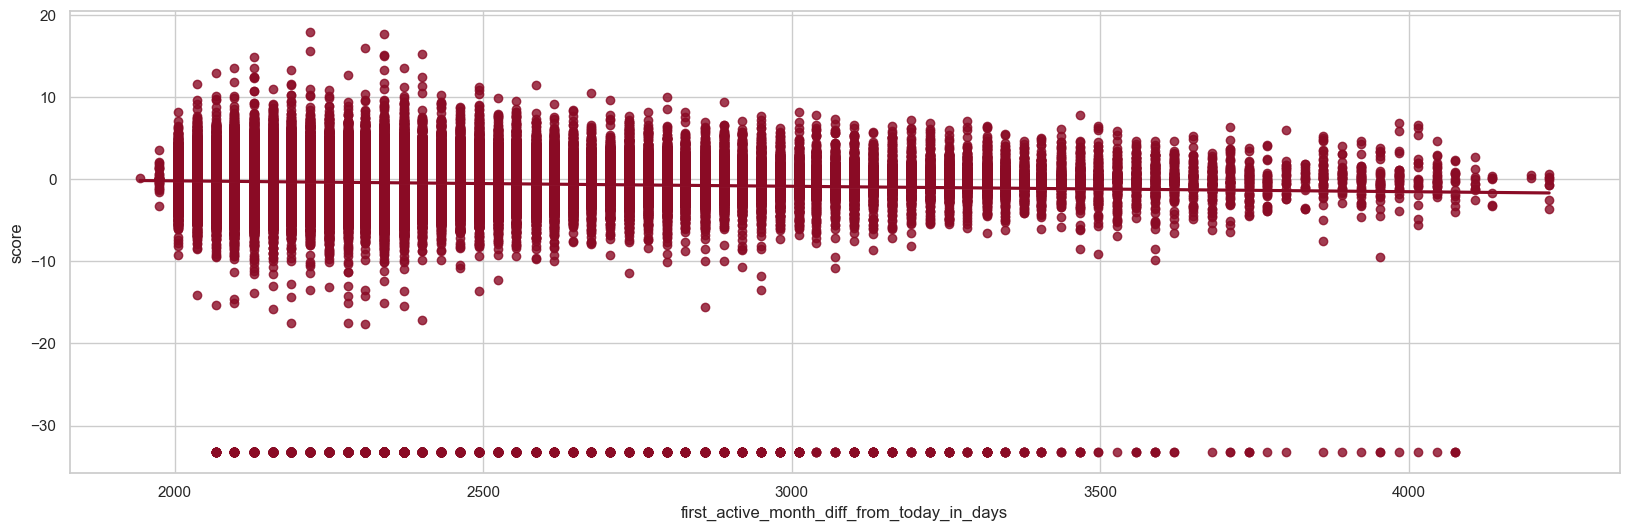

In [ ]:
sns.regplot(x='first_active_month_diff_from_today_in_days', y='score', data=merged_df)

corr_coef = merged_df['score'].corr(merged_df['first_active_month_diff_from_today_in_days'])

print('Pearson correlation coefficient:', corr_coef)

---

<a><font size="6" color = "#2471A3">Summarize Q1, Q2 and Q3</font></a>

----
<a ><font size="3"><b> (1) Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction.</b></font></a>

---

For **`merchants.csv`** we can get additional information on each merchant by produce a comprehensive picture of the merchant's business, including their product or service categories, sales and purchasing behavior, and overall performance. This information can be:

1. Engineer new features related to the merchant's business, such as their location, industry, and transaction volume.
2. Identify patterns in merchant behavior through the recent sales and purchasing behavior of the customers of the merchant.
3. Identify the most popular merchant categories.
4. Identify correlations between merchant behavior and customer loyalty.

For **`historical_transactions.csv`** and **`new_merchant_transactions.csv`**: These datasets contain information about each card's transactions. We can use this information to identify patterns in customer behavior by aggregate details about the cardholder's (CardID):
    - Identify patterns about the cardholder's spending behavior, spread of merchants, installment usage, and seasonal purchase patterns.
    - The most popular transaction categories.
    - The time of day or week when most transactions occur.
    
> By combining this transaction data with demographic information about the customers, we can perform statistical analysis to identify correlations between customer behavior and loyalty scores.

---
<a ><font size="3"><b> (2) Missing value patterns</b></font></a>

---

Variable | Pattern | Reason | Missing Number | Missing Percent | Handling Criteria
------- | -------- | -------- | -------- | --------| --------
merchant_category_2 | MNAT | The missing values are related to other variable (stateID) in the dataset and cannot be explained by the observed data alone. | 11863 | 3.545% | Impute using most frequent category.
avg_sales_lag12 | MCAT | Missing values are NOT related to other variables in the dataset | 13 | 0.004% | Deletion
transactions_category_2 | MCAT | Missing values are NOT related to other variables in the dataset | 2764609 | 8.896% | Impute using most frequent category.
transactions_category_3 | MCAT | Missing values are NOT related to other variables in the dataset | 234081 | 0.753% | Impute using most frequent category.
merchant_id | MCAT | Missing values are NOT related to other variables in the dataset | 164697 | 0.530% | Impute using most frequent category.

---
<a ><font size="3"><b>(3) Handling Outliers</b></font></a>

---
IQR is used to do an outlier check while iterating across each column. Since the IQR method is not always the best choice for finding outliers in skewed datasets, I printed the number of values in each variable (feature) that are less than the 1st percentile and greater than the 99th percentile. After that, discard any samples that fell within the first percentile or beyond the 99th percentile in any column.

---

<a ><font size="3"><b>(4) Cleaning </b></font></a>

---

- It's observed that there is a significant overlap between the between numerical_1 and numerical_2 so, I decided to drop numerical_2 column since they are almost identical.

- The installments column should have values between 0 and 12 months, but there are some values of -1 and 999. I deleted this noise values.
- I deleted the outlier from those variable (avg_sales_lag12, avg_purchases_lag12, numerical_1) as explained in the outlier section.

---

<h1 style="text-align:center;"><font color = "#2471A3">Regression Analysis</font></h1>

---


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold,SelectKBest , f_classif, chi2, RFE
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [ ]:
merged_df = pd.read_csv(r'G:\Assig 1\all_processed_data.csv')

In [ ]:
merged_df.drop(['card_id.1','card_id.2', 'merchant_id','trans_purchase_date_max','trans_purchase_date_min'],axis = 1, inplace=True)

## Baseline Model - OLS without features selection

In [ ]:
X = merged_df.drop(["score", "card_id"], axis = 1)
y = merged_df["score"]

ols = sm.OLS(y, sm.add_constant(X))
ols_fit = ols.fit()
print(ols_fit.summary(xname=['const'] + list(X.columns)))

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     80.88
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        13:19:47   Log-Likelihood:            -5.5570e+05
No. Observations:              201863   AIC:                         1.112e+06
Df Residuals:                  201791   BIC:                         1.112e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [ ]:
y_pred = ols_fit.predict(sm.add_constant(merged_df.drop(["score", "card_id"], axis = 1)))
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 3.795877847960982
R-squared: 0.02767067102546672


<a ><font size="3"><b>OBSERVATION:</b></font></a>

- The model has a low R-squared value of 0.028, indicating it explains only 2.8% of the variance in the target variable. This suggests the model has low predictive power.
- Many of the features have very high p-values and are not statistically significant in predicting the target. Only around 20-25 features seem to be significant.
- Non-normal residuals.
- Possible multicollinearity issues.

<a ><font size="2"><b>Removing insignificant predictors:</b></font></a>

- Checking correlations and VIFs to identify multicollinearity
- Feature engineering to create more predictive features
- Adding interaction terms and polynomials
- Considering regularization methods like ridge or lasso

## Pearson Correlation

In [ ]:
corr = merged_df.corr()

# Get top 5 most correlated features
corr_top5 = corr.stack().sort_values(ascending=False)[:5]
print(corr_top5, '\n')

# Get top 5 least correlated features
corr_low5 = corr.stack().sort_values(ascending=True)[:5]
print(corr_low5, '\n')

# Get correlation of a specific column, e.g. score
corr_score = corr.score.sort_values(ascending=False)
corr_score[abs(corr_score)>= 0.05]

features_mean              features_sum                1.000
features_sum               features_mean               1.000
feature_1                  feature_1                   1.000
trans_purchase_month_mode  trans_purchase_month_mode   1.000
trans_month_diff_min       trans_month_diff_min        1.000
dtype: float64 

trans_month_diff_sum       trans_purchase_amount_sum   -0.979
trans_purchase_amount_sum  trans_month_diff_sum        -0.979
                           authorized_flag_sum         -0.974
authorized_flag_sum        trans_purchase_amount_sum   -0.974
trans_purchase_month_sum   trans_purchase_amount_sum   -0.953
dtype: float64 



score                                         1.000
days_feature_2_ratio                          0.053
first_active_month_diff_from_today_in_days   -0.050
trans_purchase_date_min_diff_now             -0.063
rare_data                                    -0.071
trans_purchase_date_max_diff_now             -0.085
trans_month_diff_min                         -0.095
trans_month_diff_mean                        -0.100
trans_month_diff_max                         -0.102
Name: score, dtype: float64

C:\Users\Lap-5\AppData\Local\Temp\ipykernel_10980\497434245.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


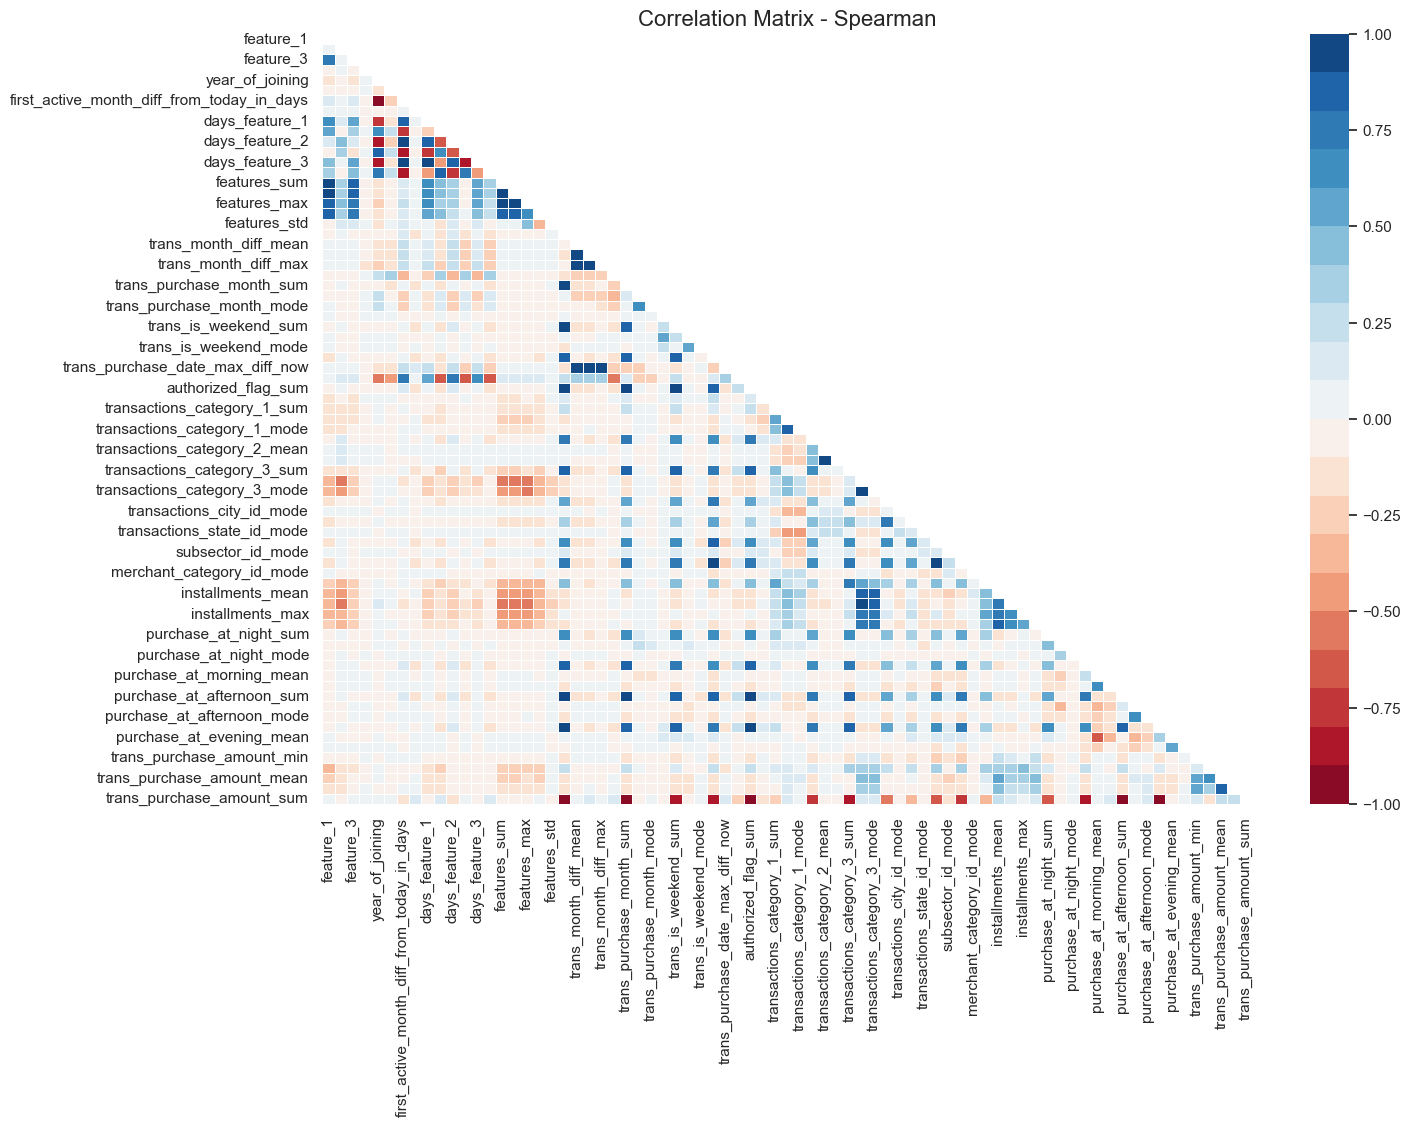

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15,10))

sns.heatmap(corr,
           vmin=-1, vmax=1,
           cmap= palette_color,
           linewidths=.5,
           linecolor='white',
           mask=mask,
           # annot=True,
           # annot_kws={"size": 4}
           )
plt.title('Correlation Matrix - Spearman', fontsize=16);

## Spearman Correlation

C:\Users\Lap-5\AppData\Local\Temp\ipykernel_10980\3757703593.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(spearman_corr, dtype=np.bool))


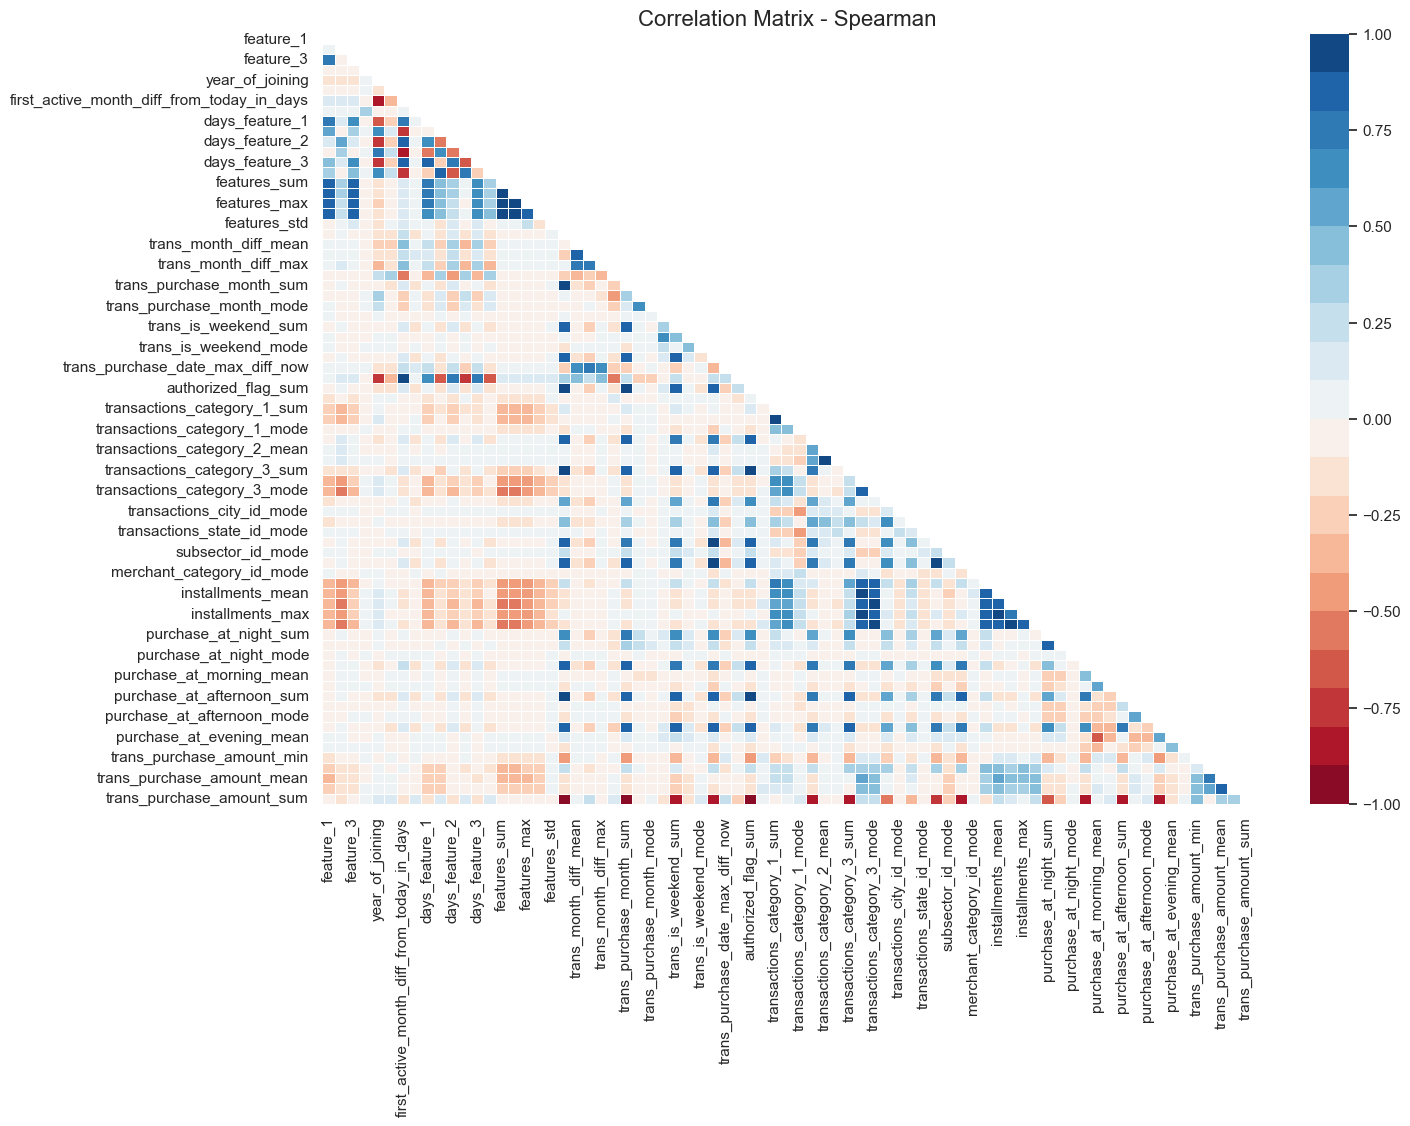

In [ ]:
plt.figure(figsize=(15,10))

spearman_corr = merged_df.corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=np.bool))

sns.heatmap(spearman_corr,
           vmin=-1, vmax=1,
           cmap= palette_color,
           linewidths=.5,
           linecolor='white',
           mask=mask,
           # annot=True,
           # annot_kws={"size": 4}
           )
plt.title('Correlation Matrix - Spearman', fontsize=16);

## Select best features using `SelectKBest`

In [ ]:
X = merged_df.drop(["score", "card_id"], axis = 1)
y = merged_df["score"]

# Drop features with zero variance
var_selector = VarianceThreshold()
temp = var_selector.fit_transform(X,y)
print(f"There are {merged_df.shape[1] - temp.shape[1]} feature with zero variance\n")

# Select top features based on F-score
reg_selector = SelectKBest(f_regression) #, k=20
selected_df1 = reg_selector.fit_transform(temp, y)

# Get names of the selected features
reg_feature_list = X.columns[reg_selector.get_support()]
print(f"{len(reg_feature_list)} features selected:")
print(reg_feature_list)

There are 2 feature with zero variance

10 features selected:
Index(['first_active_month_diff_from_today_in_days', 'rare_data',
       'days_feature_2_ratio', 'days_feature_3_ratio', 'trans_month_diff_mean',
       'trans_month_diff_min', 'trans_month_diff_max',
       'trans_purchase_date_max_diff_now', 'trans_purchase_date_min_diff_now',
       'transactions_category_1_sum'],
      dtype='object')


C:\Users\Lap-5\AppData\Local\Temp\ipykernel_10980\3062598834.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_selected, dtype=np.bool))


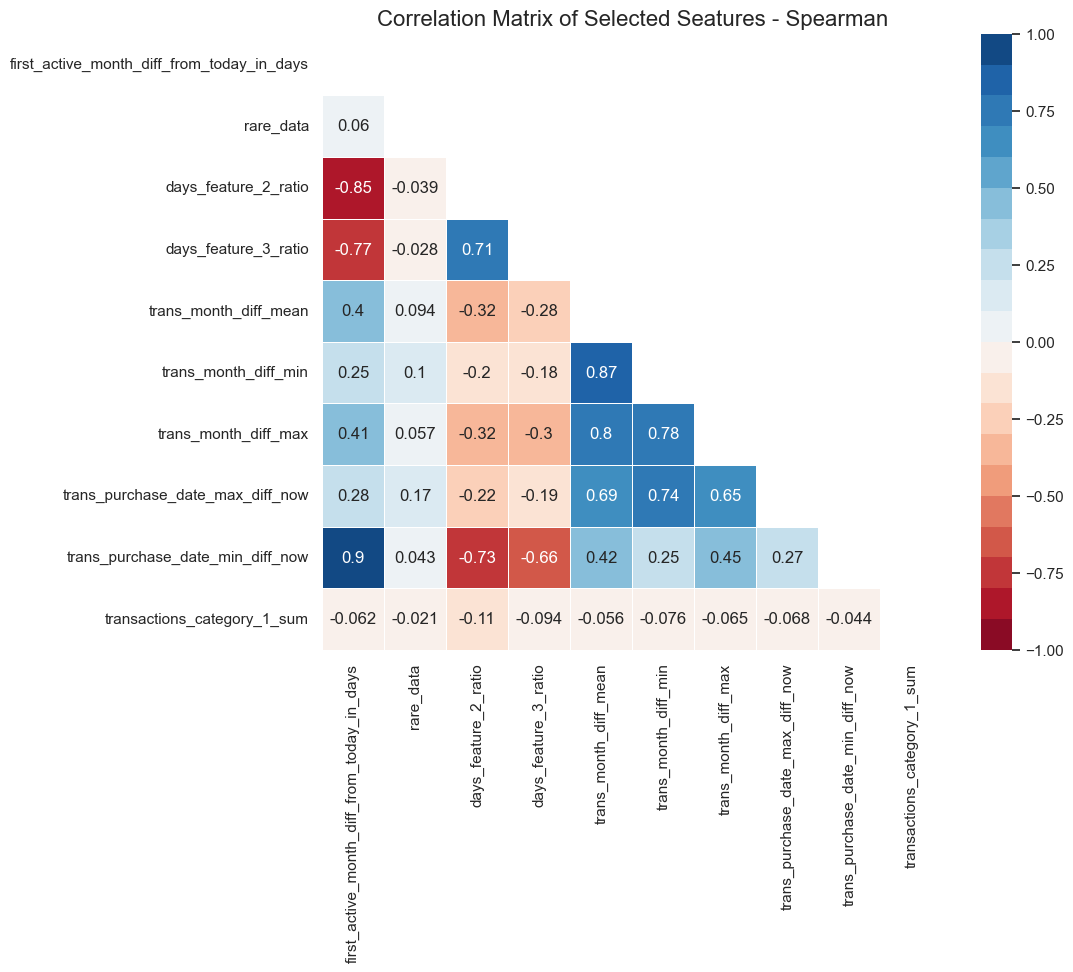

In [ ]:
plt.figure(figsize=(10,8))
corr_selected = merged_df[reg_feature_list].corr(method='spearman')
mask = np.triu(np.ones_like(corr_selected, dtype=np.bool))

sns.heatmap(corr_selected,
           vmin=-1, vmax=1,
           cmap= palette_color,
           linewidths=.5,
           linecolor='white',
           mask=mask,
           annot=True,
           annot_kws={"size": 12}
           )
plt.title('Correlation Matrix of Selected Seatures - Spearman', fontsize=16);

## Check Multicollinearity on the selected features using VIF
The VIF indicates how much the variance of an estimator is inflated by multicollinearity. It is calculated as:

$$VIF = 1 / (1 - R^2)$$
- Where R^2 is the coefficient of determination of the regressing a feature on all other features.


1. Calculates the VIF for each feature using statsmodels
2. Assigns the VIF value to a new column in the X dataset
3. Sets a VIF threshold (10) to indicate multicollinearity
4. Finds features with VIF above that threshold

    - A VIF > 10 typically indicates a potential multicollinearity issue.

### check for all exist columns

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

all_cols = merged_df.select_dtypes('number').columns
vif_df=pd.DataFrame()
vif_df['Feature']= reg_feature_list
vif = [variance_inflation_factor(merged_df[all_cols].values, i) for i in range(len(all_cols))]
vif_df['VIF'] = vif

threshold=10
multicollinearity = [col for col in vif_df[vif_df.VIF > threshold]['Feature']]

print(f'Features with VIF > {threshold} are {multicollinearity}')

### check for selected columns

In [ ]:
vif_df=pd.DataFrame()
vif_df['Feature']= reg_feature_list
vif = [variance_inflation_factor(merged_df[reg_feature_list].values, i) for i in range(len(reg_feature_list)]
vif_df['VIF'] = vif

threshold=10
multicollinearity = [col for col in vif_df[vif_df.VIF > threshold]['Feature']]

print(f'Features with VIF > {threshold} are {multicollinearity}')

<a ><font size="3"><b>OBSERVATION:</b></font></a>
This results typically indicates a potential multicollinearity issue with most of the slected features

## Split dataset to train and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

selected_X = merged_df[reg_feature_list]
y = merged_df["score"]

X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size = 0.15,random_state=0, shuffle=True)

## OLS with Feature Selection

In [ ]:
ols = sm.OLS(y, sm.add_constant(selected_X))
ols_fit = ols.fit()
print(ols_fit.summary(xname=['const'] + list(selected_X.columns)))

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     417.2
Date:                Tue, 30 May 2023   Prob (F-statistic):               0.00
Time:                        13:22:43   Log-Likelihood:            -5.5647e+05
No. Observations:              201863   AIC:                         1.113e+06
Df Residuals:                  201852   BIC:                         1.113e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [ ]:
y_pred = ols_fit.predict(sm.add_constant(X_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 3.8359087367464446
R-squared: 0.021730515172931675


In [ ]:
from math import sqrt
lr = LinearRegression();
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_rmse1 = sqrt(mean_squared_error(y_train, y_pred_train))
train_r21 = r2_score(y_train, y_pred_train)

test_rmse1 = sqrt(mean_squared_error(y_train, y_pred_train))
test_r21 = r2_score(y_test, y_pred_test)

print("Train RMSE: {:2.5f}".format(train_rmse1))
print(f'Train R-squared: {train_r21}')
print()
print("Test RMSE: {:2.5f}".format(test_rmse1))
print(f'Test R-squared: {test_r21}')

LinearRegression()

Train RMSE: 3.80579
Train R-squared: 0.019992762947832365

Test RMSE: 3.80579
Test R-squared: 0.021631460294088578


## SGD Regressor Model

In [ ]:
params = {'alpha': np.logspace(-8, 8, base=10)}
sgd_reg = SGDRegressor();
random_search = RandomizedSearchCV(sgd_reg, params, n_iter = 5,
                                   scoring = 'neg_root_mean_squared_error',
                                   cv = 5, random_state=0);
random_search.fit(selected_X, y)
print(random_search.best_params_)
print(random_search.best_score_)

RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=5,
                   param_distributions={'alpha': array([1.00000000e-08, 2.12095089e-08, 4.49843267e-08, 9.54095476e-08,
       2.02358965e-07, 4.29193426e-07, 9.10298178e-07, 1.93069773e-06,
       4.09491506e-06, 8.68511374e-06, 1.84206997e-05, 3.90693994e-05,
       8.28642773e-05, 1.75751062e-04, 3.72759372e-04, 7.90604321e-04,
       1.67683294e-03, 3...
       1.38949549e+01, 2.94705170e+01, 6.25055193e+01, 1.32571137e+02,
       2.81176870e+02, 5.96362332e+02, 1.26485522e+03, 2.68269580e+03,
       5.68986603e+03, 1.20679264e+04, 2.55954792e+04, 5.42867544e+04,
       1.15139540e+05, 2.44205309e+05, 5.17947468e+05, 1.09854114e+06,
       2.32995181e+06, 4.94171336e+06, 1.04811313e+07, 2.22299648e+07,
       4.71486636e+07, 1.00000000e+08])},
                   random_state=1, scoring='neg_root_mean_squared_error')

{'alpha': 2682.6957952797165}
-670359839420824.2


In [ ]:
sgd_reg = SGDRegressor(alpha = 2682.6957952797165)
sgd_reg.fit(X_train, y_train)

y_pred_train = sgd_reg.predict(X_train)
y_pred_test = sgd_reg.predict(X_test)

train_rmse2 = sqrt(mean_squared_error(y_train, y_pred_train))
train_r22 = r2_score(y_train, y_pred_train)

test_rmse2 = sqrt(mean_squared_error(y_train, y_pred_train))
test_r22 = r2_score(y_test, y_pred_test)

print("Train RMSE: {:2.5f}".format(train_rmse2))
print(f'Train R-squared: {train_r22}')
print()
print("Test RMSE: {:2.5f}".format(test_rmse2))
print(f'Test R-squared: {test_r22}')

SGDRegressor(alpha=2682.6957952797165)

Train RMSE: 1036750493526383.50000
Train R-squared: -7.2725847677131175e+28

Test RMSE: 1036750493526383.50000
Test R-squared: -7.146133659665799e+28


## Random Forest Regressor

In [ ]:
params = {
            'n_estimators': [10, 50, 100, 150, 250, 500],
            'max_depth': [2, 4, 6, 8, 10],
            'min_samples_split': [2, 4, 6, 8, 10],
}

random_search = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1), params, n_iter = 5,
                                   scoring = 'neg_root_mean_squared_error', cv = 5, random_state=0)
random_search.fit(selected_X, y)
random_search.best_params_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=5,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 50, 100, 150, 250,
                                                         500]},
                   random_state=0, scoring='neg_root_mean_squared_error')

{'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 8}

In [ ]:
rf = RandomForestRegressor(n_estimators= 500, min_samples_split= 6, max_depth = 8)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

train_rmse3 = sqrt(mean_squared_error(y_train, y_pred_train))
train_r23 = r2_score(y_train, y_pred_train)

train_rmse3 = sqrt(mean_squared_error(y_train, y_pred_train))
test_r23 = r2_score(y_test, y_pred_test)

print("Train RMSE: {:2.5f}".format(train_rmse3))
print(f'Train R-squared: {train_r23}')
print()
print("Test RMSE: {:2.5f}".format(test_rmse3))
print(f'Test R-squared: {test_r23}')

RandomForestRegressor(max_depth=8, min_samples_split=6, n_estimators=500)

Train RMSE: 3.37271
Train R-squared: 0.23034206157441273

Test RMSE: 0.16672
Test R-squared: 0.16588809491950207


## Gradient Boosted Decision Trees Regressor

In [ ]:
lgb_reg = lgb.LGBMRegressor(n_jobs = -1)

params = {
            'num_leaves': [30, 50, 100, 150, 200],
            'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000],
            'colsample_bytree' : [0.1, 0.4, 0.6, 0.8, 1.0],
            'learning_rate': [0.0001 ,0.001, 0.1],
            'max_depth': [4, 6, 8, 10],
}

grid_search = RandomizedSearchCV(lgb_reg, params, n_iter = 5, scoring = 'neg_mean_absolute_error',
                                 cv = 5, random_state=0)
grid_search.fit(selected_X, y)
grid_search.best_params_

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.1, 0.4, 0.6, 0.8,
                                                             1.0],
                                        'learning_rate': [0.0001, 0.001, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000, 2500, 3000],
                                        'num_leaves': [30, 50, 100, 150, 200]},
                   random_state=0, scoring='neg_mean_absolute_error')

{'num_leaves': 150,
 'n_estimators': 1500,
 'max_depth': 6,
 'learning_rate': 0.001,
 'colsample_bytree': 0.6}

In [ ]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)

y_pred_train = lgb_reg.predict(X_train)
y_pred_test = lgb_reg.predict(X_test)

train_rmse4 = sqrt(mean_squared_error(y_train, y_pred_train))
train_r24 = r2_score(y_train, y_pred_train)

test_rmse4 = sqrt(mean_squared_error(y_train, y_pred_train))
test_r24 = r2_score(y_test, y_pred_test)

print("Train RMSE: {:2.5f}".format(train_rmse4))
print(f'Train R-squared: {train_r24}')
print()
print("Test RMSE: {:2.5f}".format(test_rmse4))
print(f'Test R-squared: {test_r24}')

LGBMRegressor()

Train RMSE: 3.22854
Train R-squared: 0.2947324187467112

Test RMSE: 3.22854
Test R-squared: 0.17213017750886372


## Models Conclusion

In [ ]:
results = {
    'Model': ['Linear Regression','SGD Regressor','Random Forest Regressor','LGBMRegressor'],
    'Train RMSE':  [train_rmse1, train_rmse2, train_rmse3, train_rmse4],
    'Test RMSE': [test_rmse1, test_rmse2, test_rmse3, test_rmse4],
    'Train R-squared':[train_r21, train_r22, train_r23, train_r24],
    'Test R-squared':[test_r21, test_r22, test_r23, test_r24],
}

results_df = pd.DataFrame(results)
results_df

,Model,Train RMSE,Test RMSE,Train R-squared,Test R-squared
0,Linear Regression,3.806,3.806,0.020,0.022
1,SGD Regressor,1036750493526383.500,1036750493526383.500,-72725847677131175175519207424.000,-71461336596657993090705915904.000
2,Random Forest Regressor,3.373,0.167,0.230,0.166
3,LGBMRegressor,3.229,3.229,0.295,0.172


<a ><font size="3"><b>CONCLUSION:</b></font></a>
The LGBM Regressor seems to be performing the best out of the four models, as it has the lowest RMSE on the train set and a higher R-squared value than the others.